# Jan Izydorczyk
# Sprawozdanie 10

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook
from mpmath import nstr, mpf

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


## Metoda Euler

Metoda opiera się na aproksymacji zcałkowanego wyrażenia za pomocą metody prostokątów. Robimy to iteracyjnie, od jednego końca przedziału do drugiego, robiąc ustalony krok $h$, powoli generując wartości szukanej funkcji. Jest to metoda jawna pierwszego rzędu. 

In [2]:
def euler_df(f, interval, initial_point, h=None, n_parts=None):
    a, b = interval
    if h is None:
        h = (b - a) / n_parts
    elif n_parts is None:
        n_parts = int((b-a) / h)
    t = a
    u = np.copy(initial_point)
    result = [u]
    ts = np.linspace(a, b - h, n_parts)
    for t in ts:
        u = u + h * f(t, u)
        result.append(u)
    return np.linspace(a, b, n_parts + 1), np.array(result)

In [3]:
from scipy.integrate import solve_ivp

In [4]:
def f(t, x):
    return 2 + (x - t - 1)**2

In [5]:
equality = f, (1, 1.5625), 2

In [6]:
ts, us = euler_df(*equality, n_parts=72)
lib_us = solve_ivp(f, (1, 2), [2], t_eval=ts)
real_us = 1 + ts + np.tan(ts - 1) 

<IPython.core.display.Javascript object>


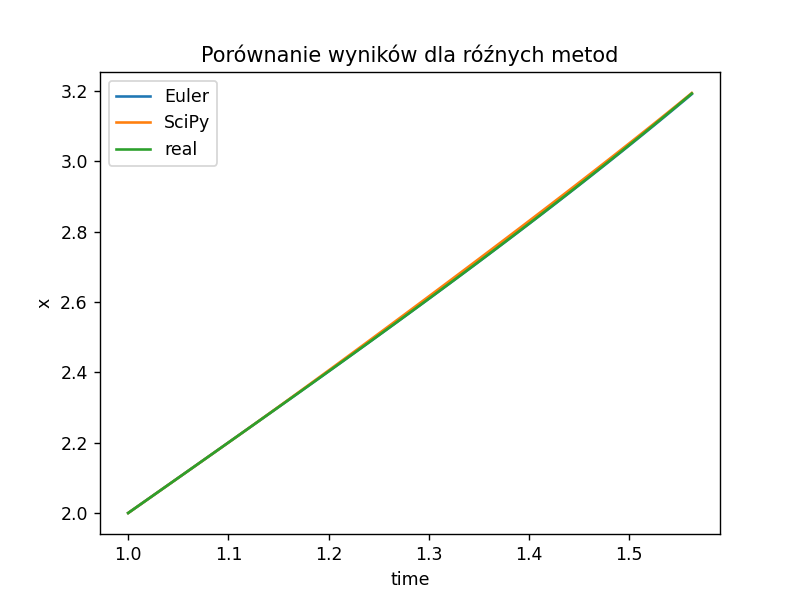

In [7]:
plt.plot(ts, us, label='Euler')
plt.plot(ts, lib_us.y.T, label='SciPy')
plt.plot(ts, real_us, label='real')

plt.xlabel('time')
plt.ylabel('x')
plt.title('Porównanie wyników dla róźnych metod')

_ = plt.legend()

## Metoda Rungego-Kutty
Metoda analogicznie jak metoda Eulera stara się aproksymować całkowanie funkcji, ale robi to poprzez przybliżanie kolejnych wspołczynników rozwinięcia szeregu Taylora. Może to robić dla dowolnego stopnia, zwiększając zbieżność względem kroku $h$.

W zastosowaniach praktycznych stosuje się czwarty rząd.

In [9]:
def runge_kutta_df(f, interval, initial_point, h=None, n_parts=None):
    a, b = interval
    if h is None:
        h = (b - a) / n_parts
    elif n_parts is None:
        n_parts = int((b-a) / h)
    t = a
    x = np.copy(initial_point)
    res = [x]
    for _ in range(0, n_parts):
        k1 = h * f(t, x)
        k2 = h * f(t + h/2, x + k1/2)
        k3 = h * f(t + h/2, x + k2/2)
        k4 = h * f(t + h, x + k3)
        
        x_new = x + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        res.append(x_new)
        x = x_new
    return np.linspace(a, b, n_parts + 1), np.array(res)

In [10]:
def runge_kutta_df(f, interval, initial_point, h=None, n_parts=None):
    a, b = interval
    if h is None:
        h = (b - a) / n_parts
    elif n_parts is None:
        n_parts = int((b - a) / h)
    y  = np.array(initial_point)
    res = [y]
    t = a
    for _ in range(0, n_parts):
        t = t
        
        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + h/2, y + k2/2)
        k4 = h * f(t + h, y + k3)
        
        y = y + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        
        t = t + h
        res.append(y)
    return np.linspace(a, b, n_parts + 1), np.array(res)

In [11]:
ts, rk_us = runge_kutta_df(*equality, n_parts=72)

<IPython.core.display.Javascript object>


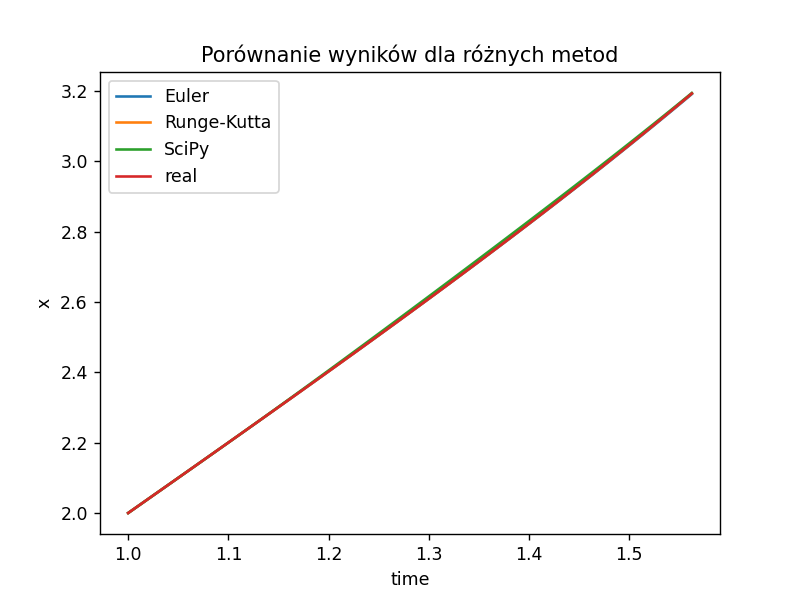

In [12]:
fig = plt.figure()

plt.plot(ts, us, label='Euler')
plt.plot(ts, rk_us, label='Runge-Kutta')
plt.plot(ts, lib_us.y.T, label='SciPy')
plt.plot(ts, real_us, label='real')

plt.xlabel('time')
plt.ylabel('x')
plt.title('Porównanie wyników dla różnych metod')

plt.legend()

## Wahadło

$$
\frac{d^2 \theta}{dt^2} + \frac{g}{l} \sin(\theta) = 0 \\
\omega = \frac{d\theta}{dt} \\
\frac{d \theta}{dt} = \omega\\
\frac{d\omega}{dt} = -\frac{g}{l} \sin(\theta)\\
$$


In [13]:
def pend(t, x, g, l):
    theta, omega = x
    dydt = np.array([omega, - (g / l) * np.sin(theta)])
    return dydt

## Małe wychylenie początkowe, zerowa startowa prędkość kątowa

In [14]:
g = 9.81
l = 1
y0 = np.array([np.pi * 0.1, 0.0])
# t = np.linspace(0, 20, 301)
pend_ac = (lambda t, x: pend(t, x, g, l), (0, 20), y0)

In [15]:
from matplotlib import animation

In [16]:
def animate_pendulum(thetas, ls, dt, title='', fig_ax=None):
    lim = np.sum(np.abs(ls)) * (1 + 1/(thetas.shape[1] + 1))
    if fig_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-lim, lim), ylim=(-lim, lim))
    else:
        fig, ax = fig_ax
    ax.set_aspect('equal')
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    ls = ls.reshape(1, -1)
    xs = ls * np.sin(thetas)
    ys = -ls * np.cos(thetas)
    
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        thisx = [0, *np.cumsum(xs[i])]
        thisy = [0, *np.cumsum(ys[i])]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*dt))
        return line, time_text


    ani = animation.FuncAnimation(fig, animate, range(1, len(thetas)),
                                  interval=dt*1000, blit=True, init_func=init)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if fig_ax is None:
        fig.tight_layout()
        plt.show()
    return ani

In [17]:
def beuty(x):
    return nstr(mpf(x), 3)

In [18]:
def charts_pendulum(poses, velos, init, dt, ts, title='', fig_ax = None, draw_vel=True):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
    else:
        fig, ax = fig_ax
    n = poses.shape[1]
    cs = np.linspace(1, 0.6, n)
    for i in range(n):
        pos, vel = poses[:, i], velos[:, i]
        c = cs[i]
        ax.plot(ts, pos, label=title+f' $\\theta_{i} (t)$', zorder=1)
        if draw_vel:
            ax.plot(ts, vel, label=title+f' $\omega_{i} (t)$', zorder=0)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Angle[rad], Angular velocity[rad\s]')
    ax.legend()
    
    if fig_ax is None:
        title = title + f'\n$\\theta, \omega$ ~ t\nh={beuty(dt)}, initial={init[2]} '
        fig.suptitle(title)
        fig.tight_layout()
        plt.show()
    else:
        return fig, ax

Animacje zostały stworzone dla kroku $h=0.005$.

### Wahadło, metoda Eulera

In [19]:
dt = 0.005
ts, us = euler_df(*pend_ac, h=dt)
pos_euler, vel_euler = us[:, 0].reshape(-1, 1), us[:, 1].reshape(-1, 1)

<IPython.core.display.Javascript object>


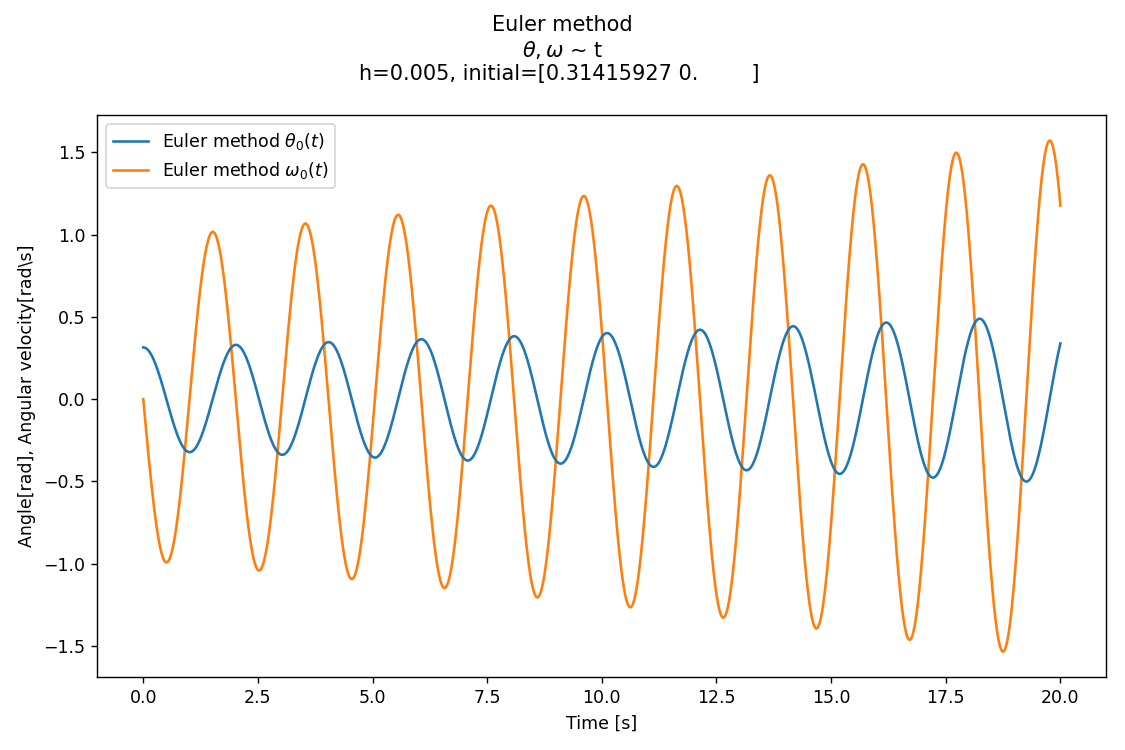

In [20]:
charts_pendulum(pos_euler, vel_euler, pend_ac, dt, ts, 'Euler method')

<IPython.core.display.Javascript object>


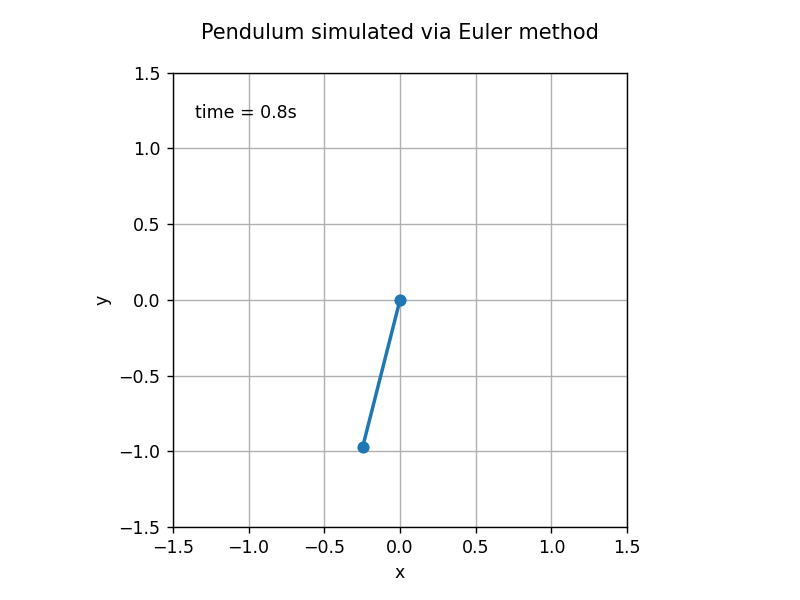

In [22]:
ani = animate_pendulum(pos_euler.reshape(-1, 1), np.array([1]), dt, title='Pendulum simulated via Euler method\n')
# ani.save('Euler.gif', writer='imagemagick', fps=60)

Metoda nie daje poprawnych wyników, sukcesywnie zwiększając energię całkowitą układu.

### Wahadło, metoda Rungego-Kutty

In [23]:
dt = 0.005
ts, us = runge_kutta_df(*pend_ac, h=dt)
pos_runge, vel_runge = us[:, 0].reshape(-1, 1), us[:, 1].reshape(-1, 1)

<IPython.core.display.Javascript object>


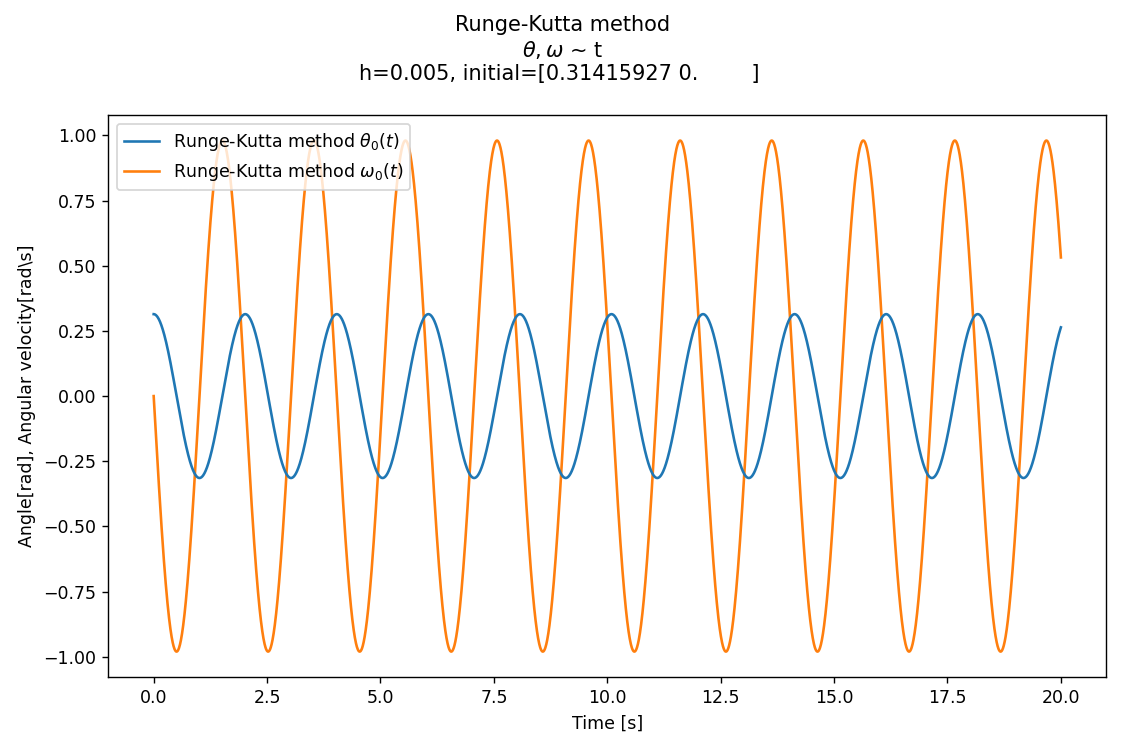

In [24]:
charts_pendulum(pos_runge, vel_runge, pend_ac, dt, ts, 'Runge-Kutta method')

<IPython.core.display.Javascript object>


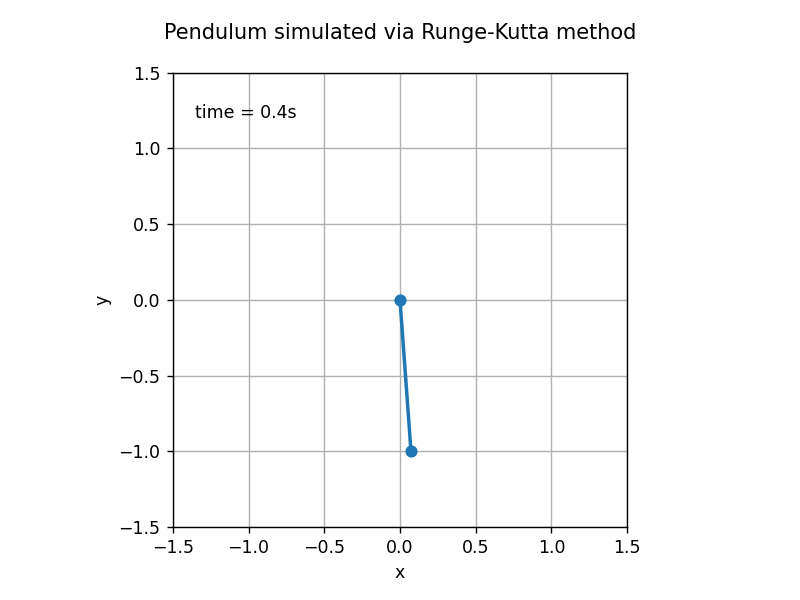

In [25]:
title = 'Pendulum simulated via Runge-Kutta method\n'
ani = animate_pendulum(pos_runge.reshape(-1, 1), np.array([1]), dt, title=title)
# ani.save('Runge-Kutta.gif', writer='imagemagick', fps=60)

Metoda ta już dla wartości $h=0.005$ daje zadowalające rezultaty, generując ruch harmoniczny.

## Wahadło funkcja biblioteczna

In [26]:
def scipy_df(f, interval, initial_point, h=None, n_parts=None):
    a, b = interval
    if h is None:
        h = (b - a) / n_parts
    elif n_parts is None:
        n_parts = int((b - a) / h)
        
    ts = np.linspace(a, b, n_parts + 1)
    lib_us = solve_ivp(fun=f, t_span=interval, y0=initial_point, t_eval=ts)
    lib_us = lib_us.y.T    
    return ts, lib_us

<IPython.core.display.Javascript object>


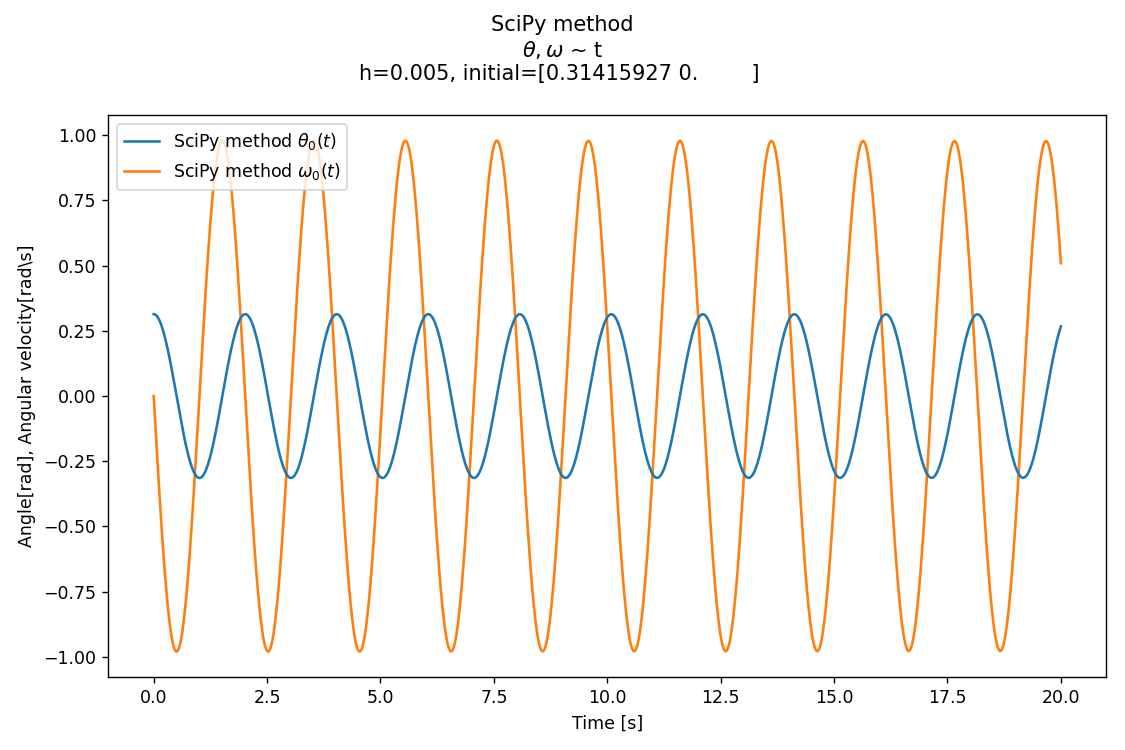

In [27]:
dt = 0.005
ts, lib_us = scipy_df(*pend_ac, h=dt)
pos_lib, vel_lib = lib_us[:, 0].reshape(-1, 1), lib_us[:, 1].reshape(-1, 1)
charts_pendulum(pos_lib, vel_lib, pend_ac, dt, ts, 'SciPy method')

<IPython.core.display.Javascript object>


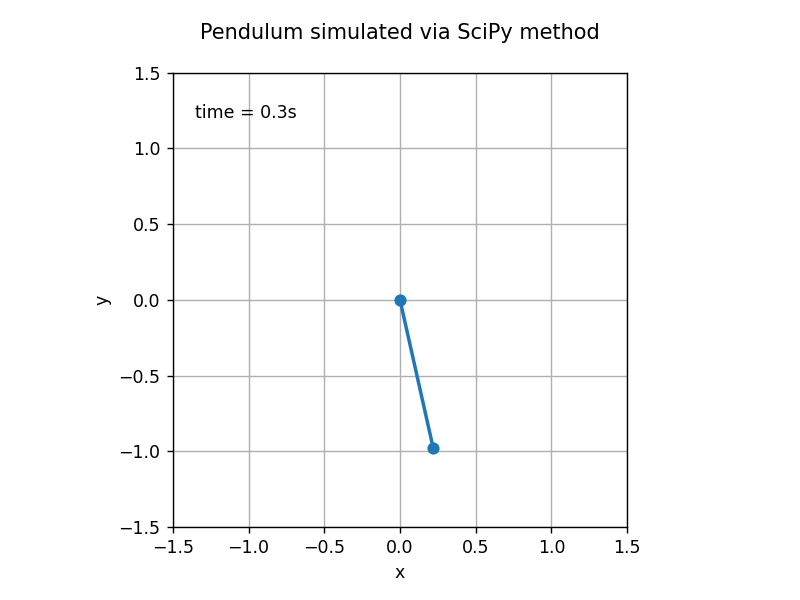

In [29]:
title = 'Pendulum simulated via SciPy method\n'
ani = animate_pendulum(pos_lib.reshape(-1, 1), np.array([1]), dt, title=title)
# ani.save('SciPy.gif', writer='imagemagick', fps=60)

Wnioski jak dla metody Rungego-Kutty

## Porównanie metod dla róznych wartości h

In [30]:
def compare_charts(ac, dt, methods):
    n = len(methods)
    fig, axs = plt.subplots(n + 1, 1, figsize=(8, 4 * (n + 1)))
    comp_ax = axs[-1]
    for method, ax in zip(methods, axs):
        ts, us = method(*ac, h=dt)
        pos, vel = us[:, 0::2], us[:, 1::2]
        if len(pos.shape) == 1:
            pos, vel = pos.reshape(-1, 1), vel.reshape(-1, 1)
        charts_pendulum(pos, vel, ac, dt, ts, method.__name__, (fig, ax))
        ax.set_title(method.__name__)
        charts_pendulum(pos, vel, ac, dt, ts, method.__name__, (fig, comp_ax), draw_vel=False)
    comp_ax.set_title('Methods angle comparison')
    title = f'Comparison for\nh={dt}'
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


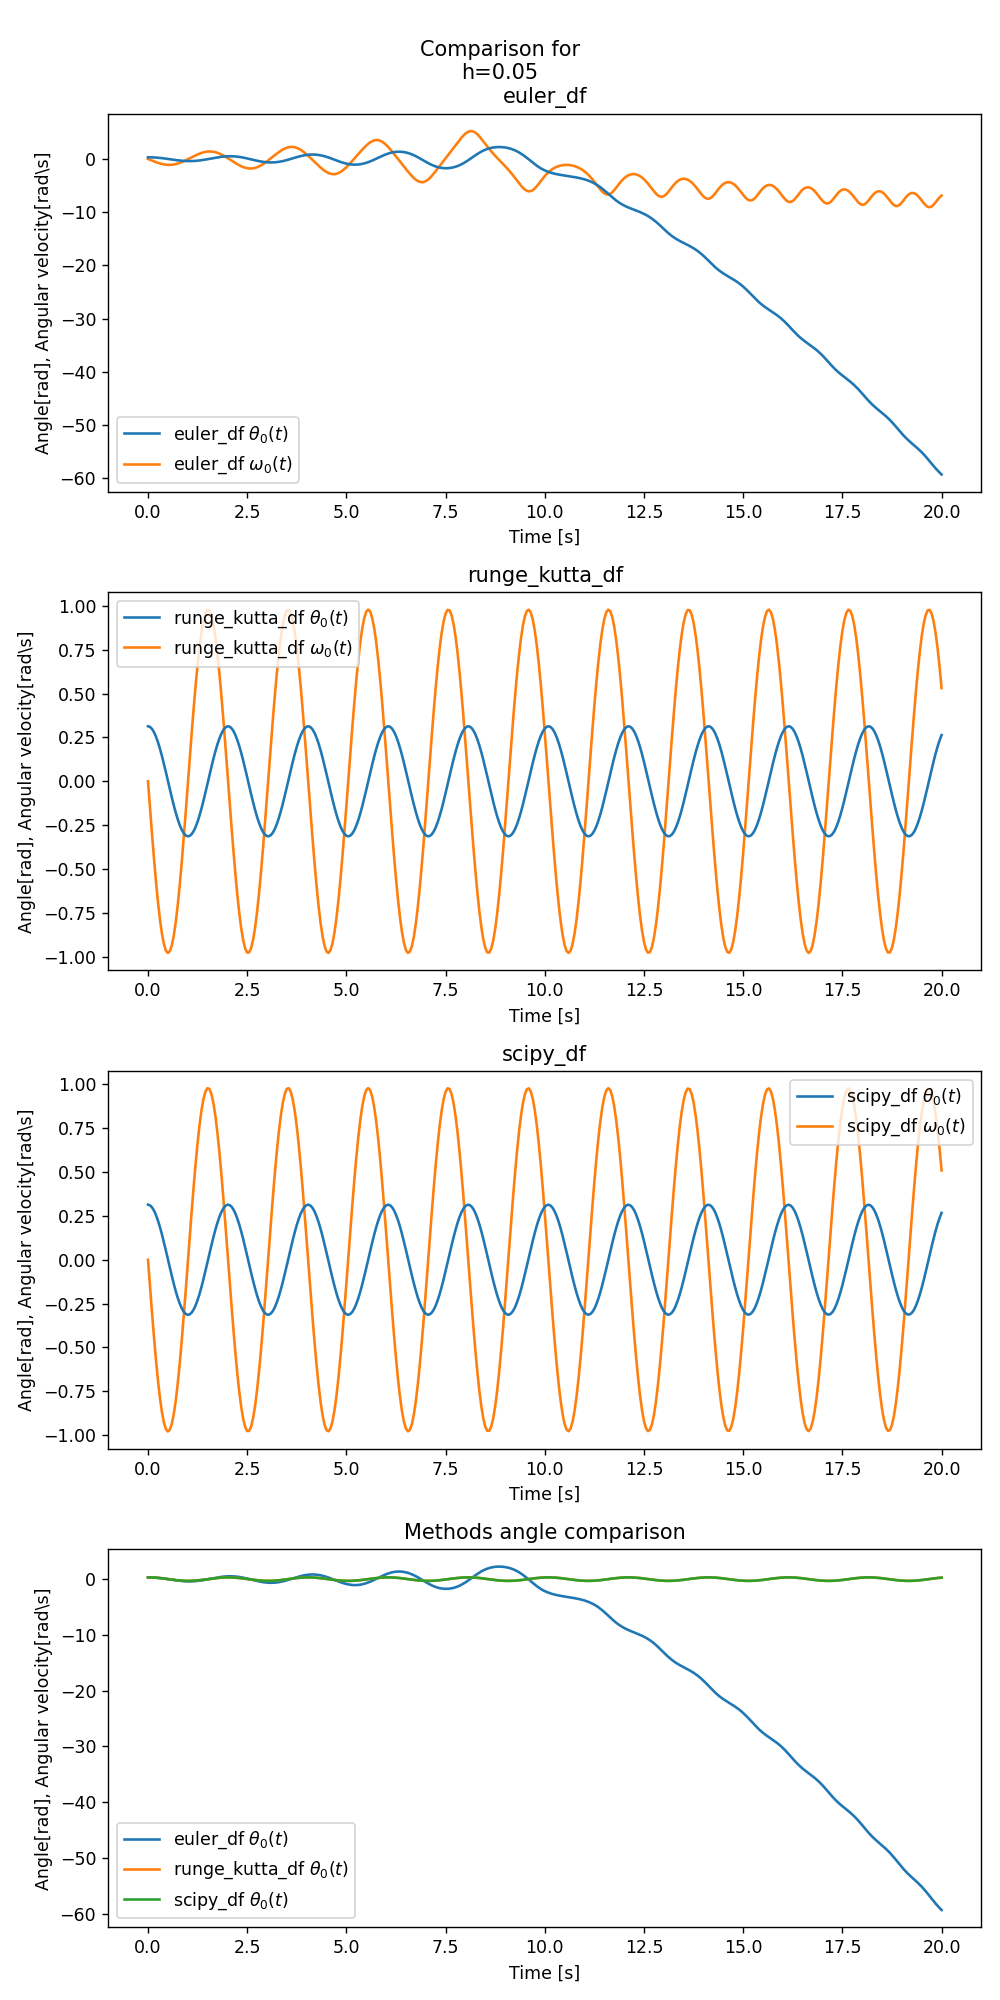

In [31]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac, 0.05, methods)

Dla $h=0.05$ metoda Eulera bardzo szybko destabilizuje układ. Pozostałe metody, nawet jak na taką duża wartość kroku $h$ dają zadowalające wyniki.

<IPython.core.display.Javascript object>


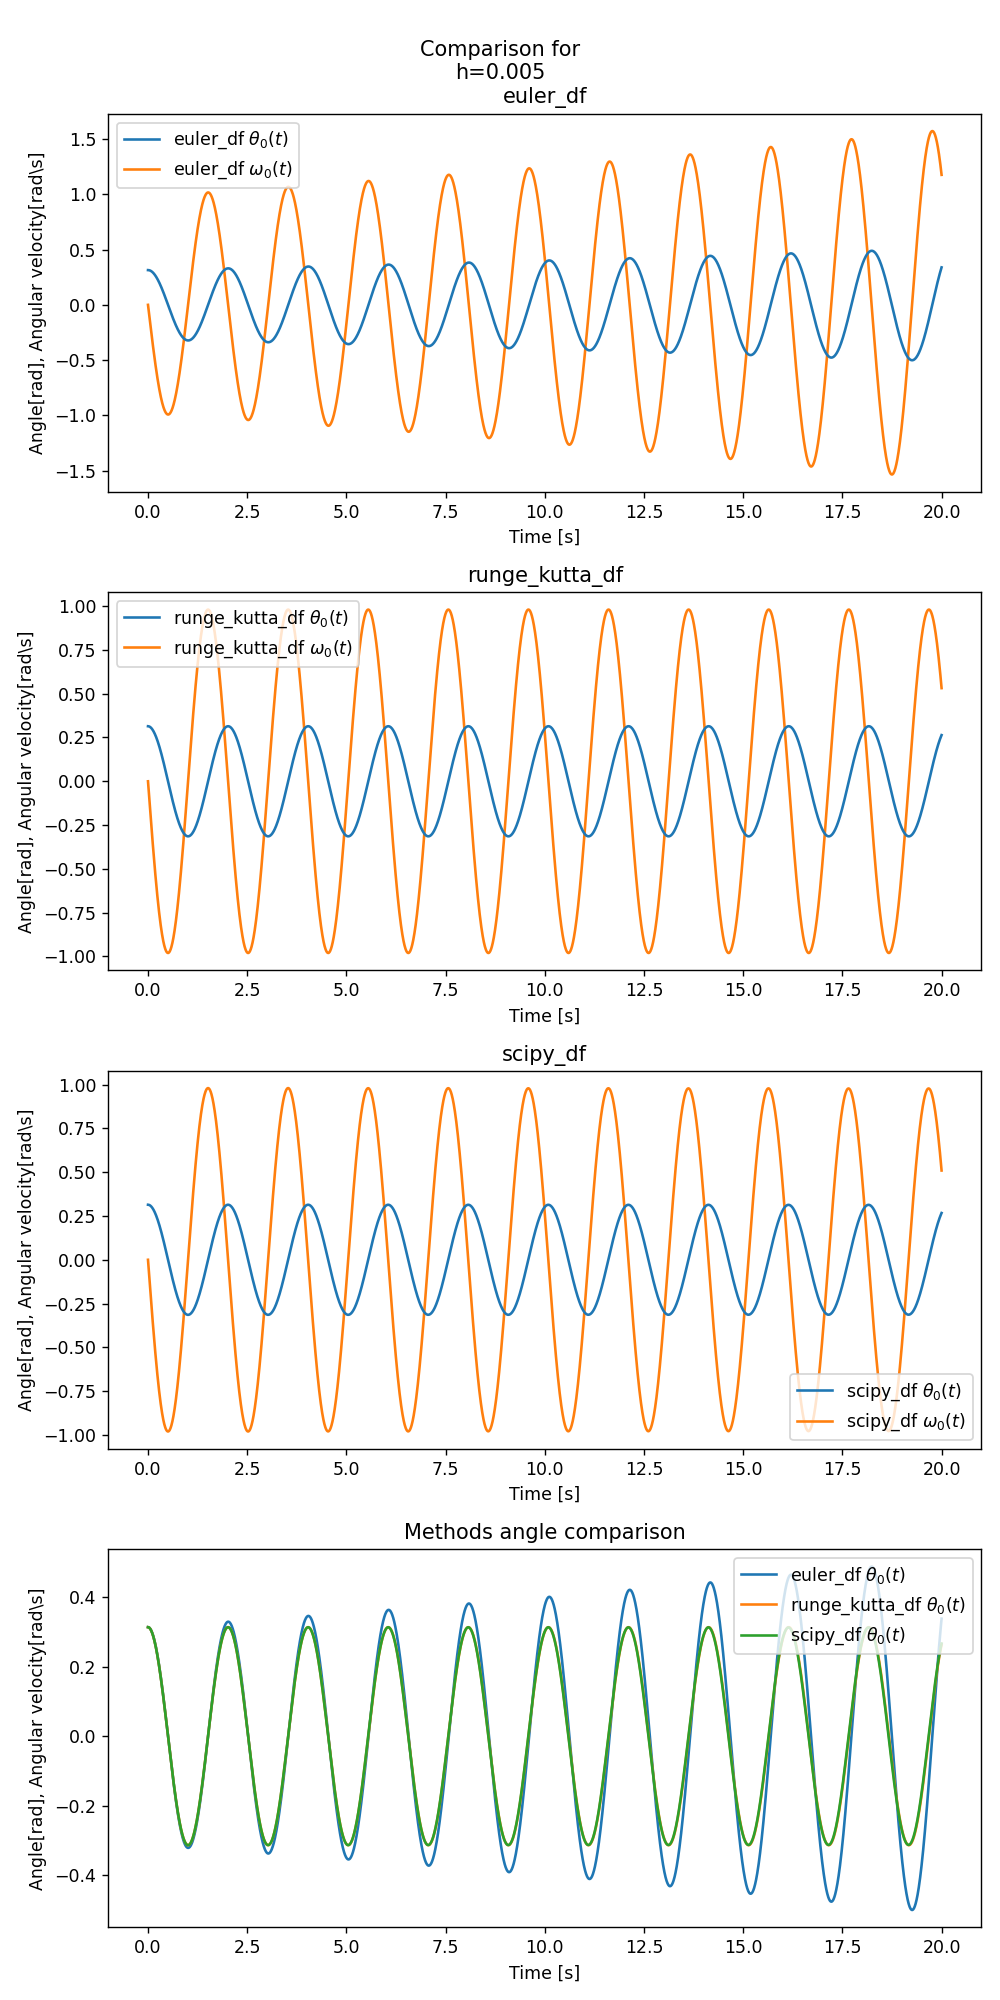

In [32]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac, 0.005, methods)

Dla $h=0.005$ metoda Eulera przestała aż tak bardzo destabilizować układ, ale dalej zwiększa jego energię całkowitą.

<IPython.core.display.Javascript object>


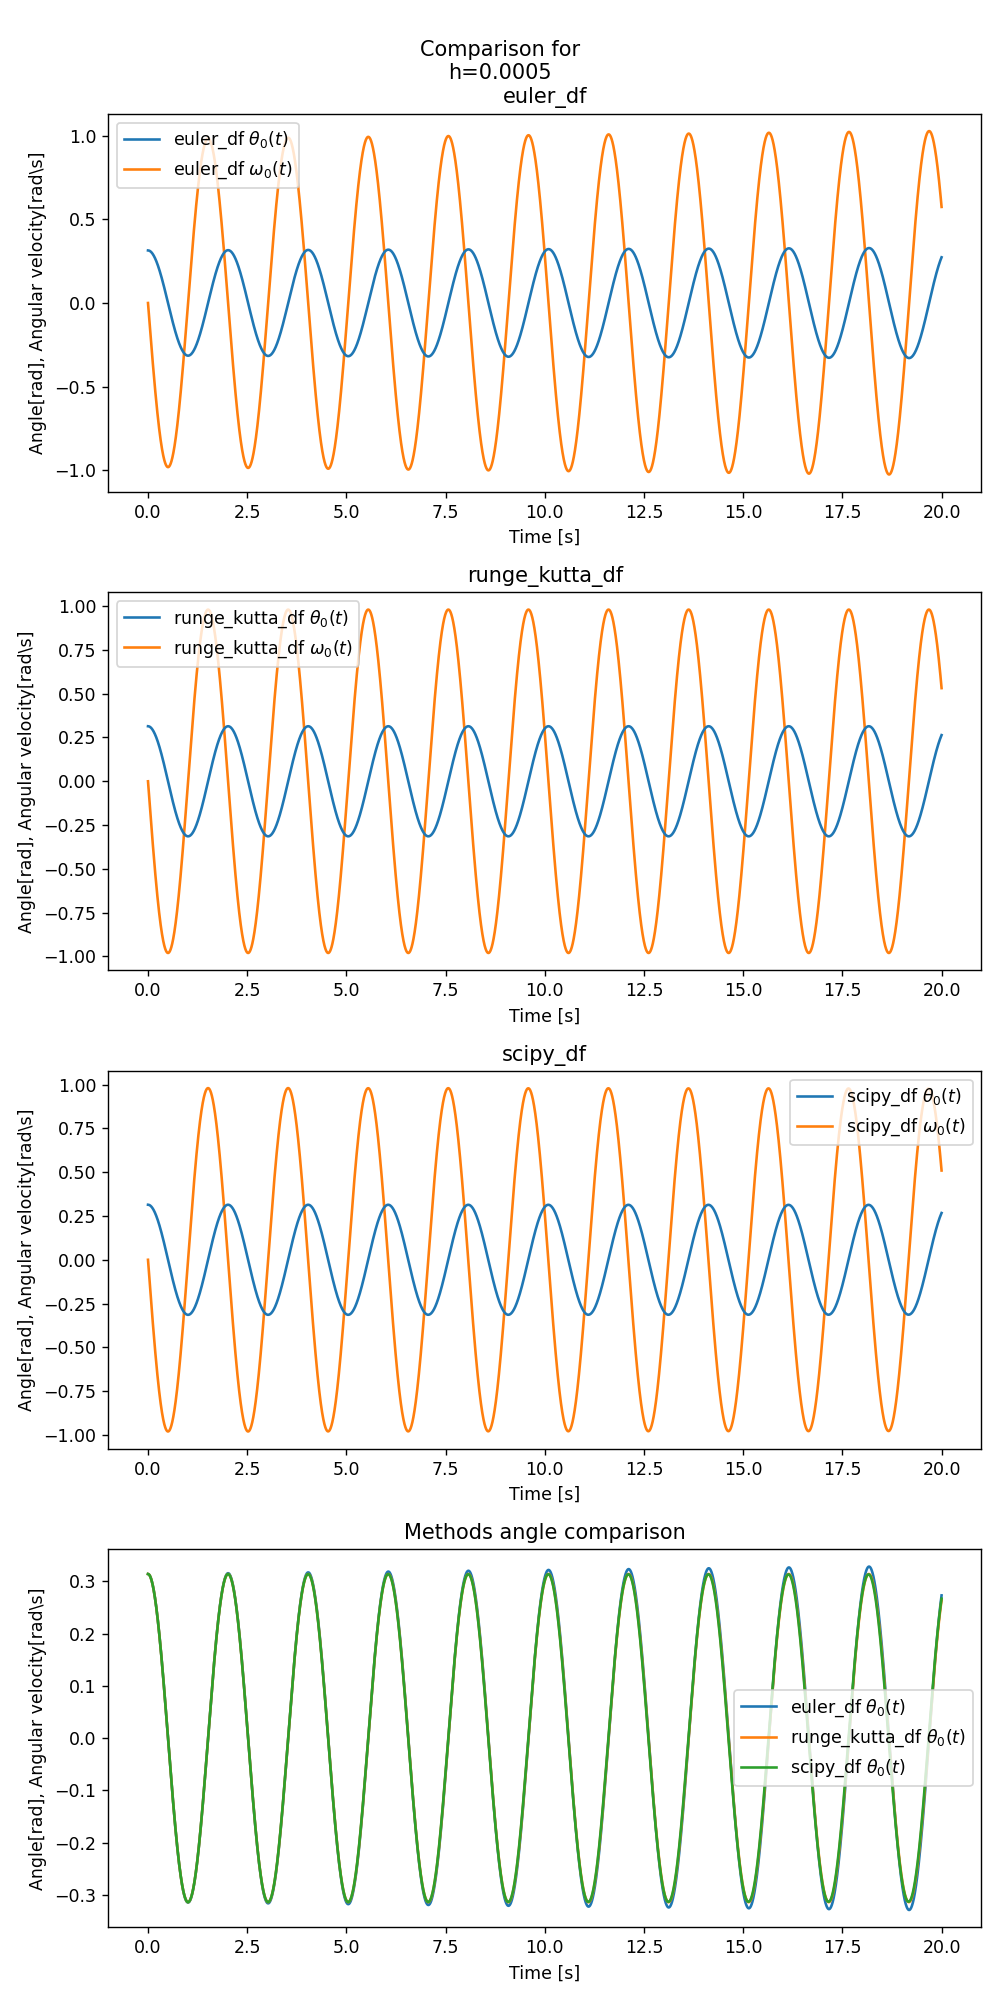

In [30]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac, 0.0005, methods)

Dla $h=0.0005$ metody daja analogiczne wyniki, metoda Eulera dalej w małym stopniu zwiększa energię układu.

## Układ o znacznym wychyleniu początkowym 

In [33]:
g = 9.81
l = 1
y0 = np.array([np.pi - 0.1, 0.0])
# t = np.linspace(0, 20, 301)
pend_ac_extr = (lambda t, x: pend(t, x, g, l), (0, 20), y0)

## Euler

In [34]:
dt = 0.005
ts, us = euler_df(*pend_ac_extr, h=dt)
pos_euler_extr, vel_euler_extr = us[:, 0].reshape(-1, 1), us[:, 1].reshape(-1, 1)

<IPython.core.display.Javascript object>


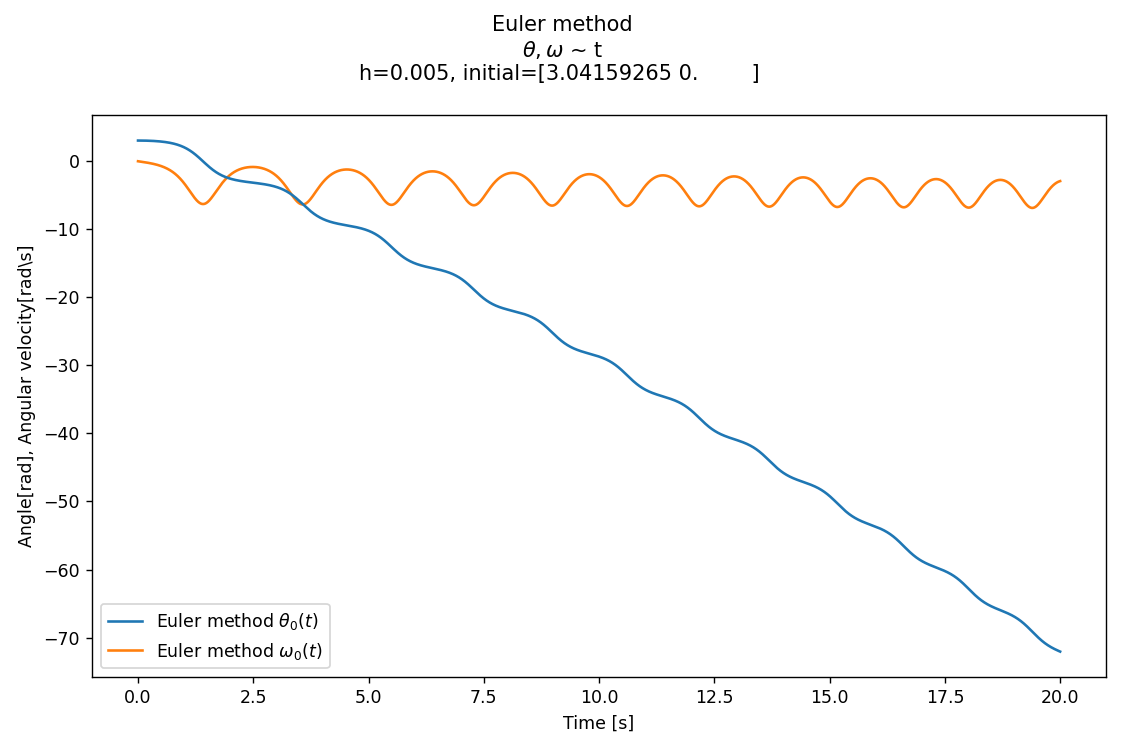

In [35]:
charts_pendulum(pos_euler_extr, vel_euler_extr, pend_ac_extr, dt, ts, 'Euler method')

<IPython.core.display.Javascript object>


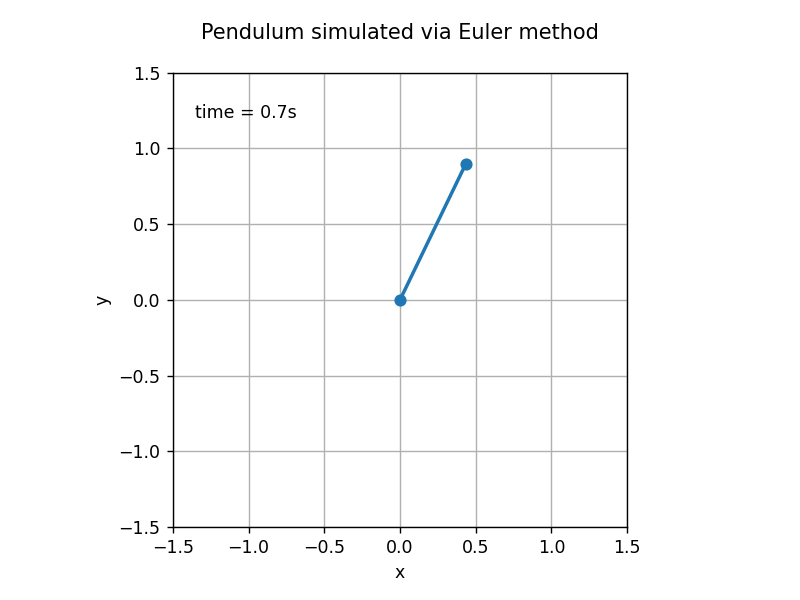

In [36]:
ani = animate_pendulum(pos_euler_extr.reshape(-1, 1), np.array([1]), dt, title='Pendulum simulated via Euler method\n')
# ani.save('EulerExtr.gif', writer='imagemagick', fps=60)

Ponownie, totalna porażka.

## Runge-Kutta

In [37]:
dt = 0.005
ts, us = runge_kutta_df(*pend_ac_extr, h=dt)
pos_runge_extr, vel_runge_extr = us[:, 0].reshape(-1, 1), us[:, 1].reshape(-1, 1)

<IPython.core.display.Javascript object>


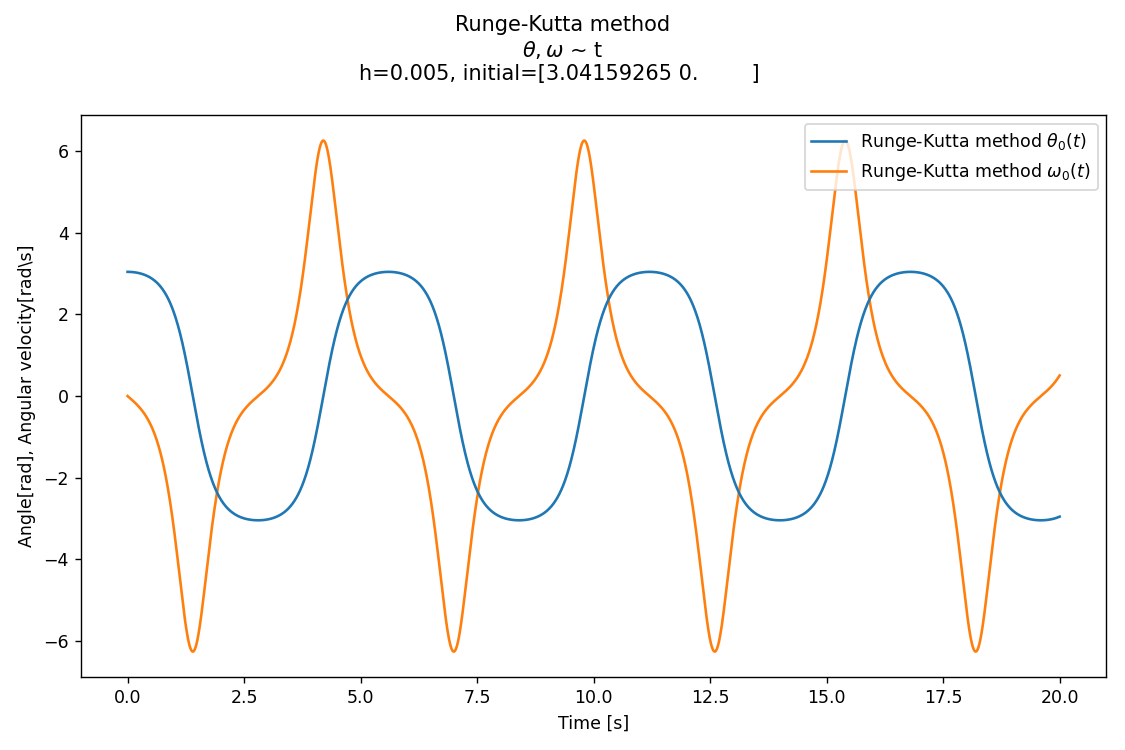

In [38]:
charts_pendulum(pos_runge_extr, vel_runge_extr, pend_ac_extr, dt, ts, 'Runge-Kutta method')


<IPython.core.display.Javascript object>


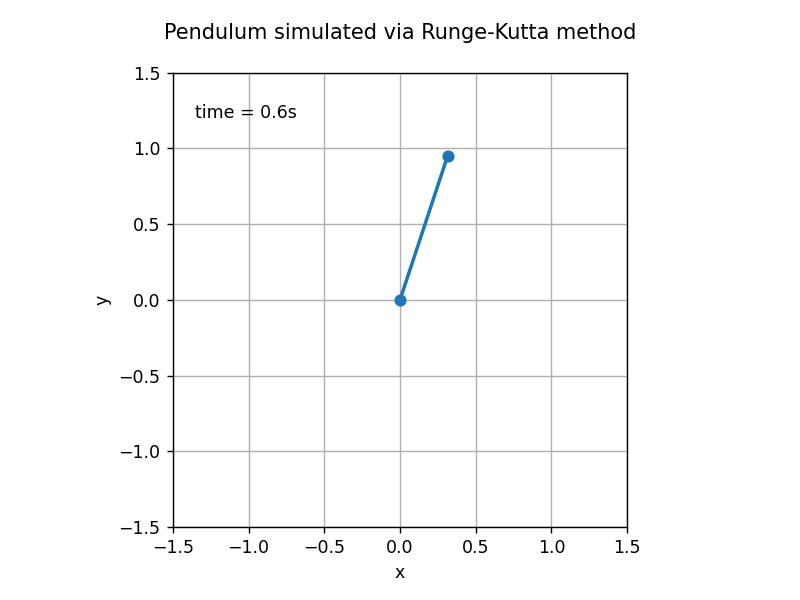

In [39]:
ani = animate_pendulum(pos_runge_extr.reshape(-1, 1), np.array([1]), dt, title='Pendulum simulated via Runge-Kutta method\n')
# ani.save('RungeExtr.gif', writer='imagemagick', fps=60)

Jak się okazało, metoda Rungego-Kutty daje poprawne wyniki.

## Funkcja biblioteczna

In [40]:
dt = 0.005
ts, us = scipy_df(*pend_ac_extr, h=dt)
pos_scipy_extr, vel_scipy_extr = us[:, 0].reshape(-1, 1), us[:, 1].reshape(-1, 1)


<IPython.core.display.Javascript object>


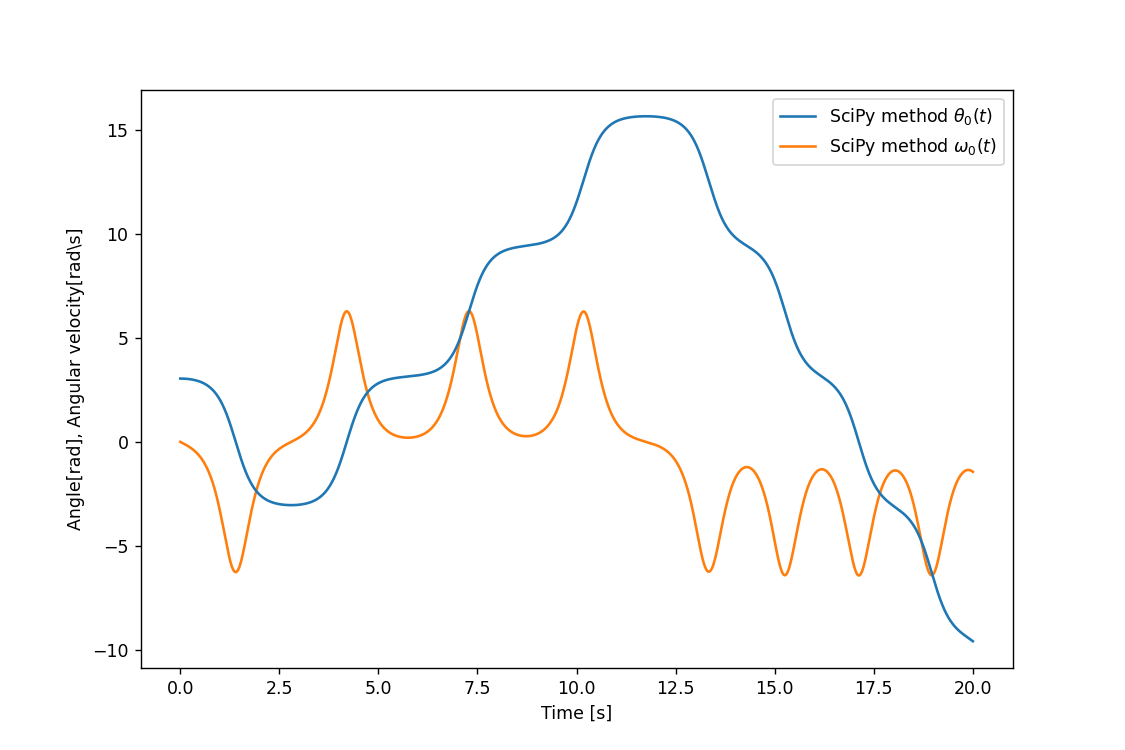

(<Figure size 900x600 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Angle[rad], Angular velocity[rad\\s]'>)

In [39]:
charts_pendulum(pos_scipy_extr, vel_scipy_extr, pend_ac_extr, dt, ts, 'SciPy method')


<IPython.core.display.Javascript object>


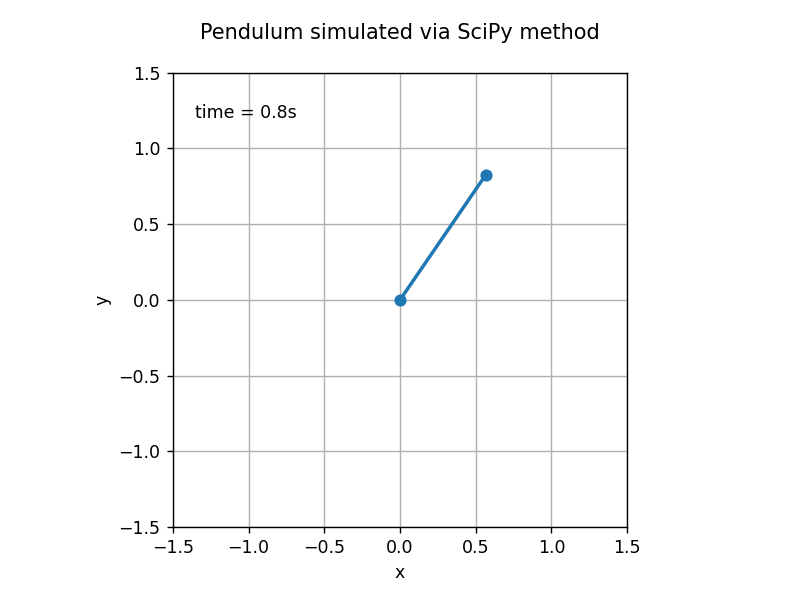

In [41]:
ani = animate_pendulum(pos_scipy_extr.reshape(-1, 1), np.array([1]), dt, title='Pendulum simulated via SciPy method\n')
# ani.save('SciPyExtr.gif', writer='imagemagick', fps=60)

Co ciekawe, funkcja biblioteczna nie zachowuje energii układu, w losowych momentach wytracając lub zwiększajac ją. 

## Comparisons

<IPython.core.display.Javascript object>


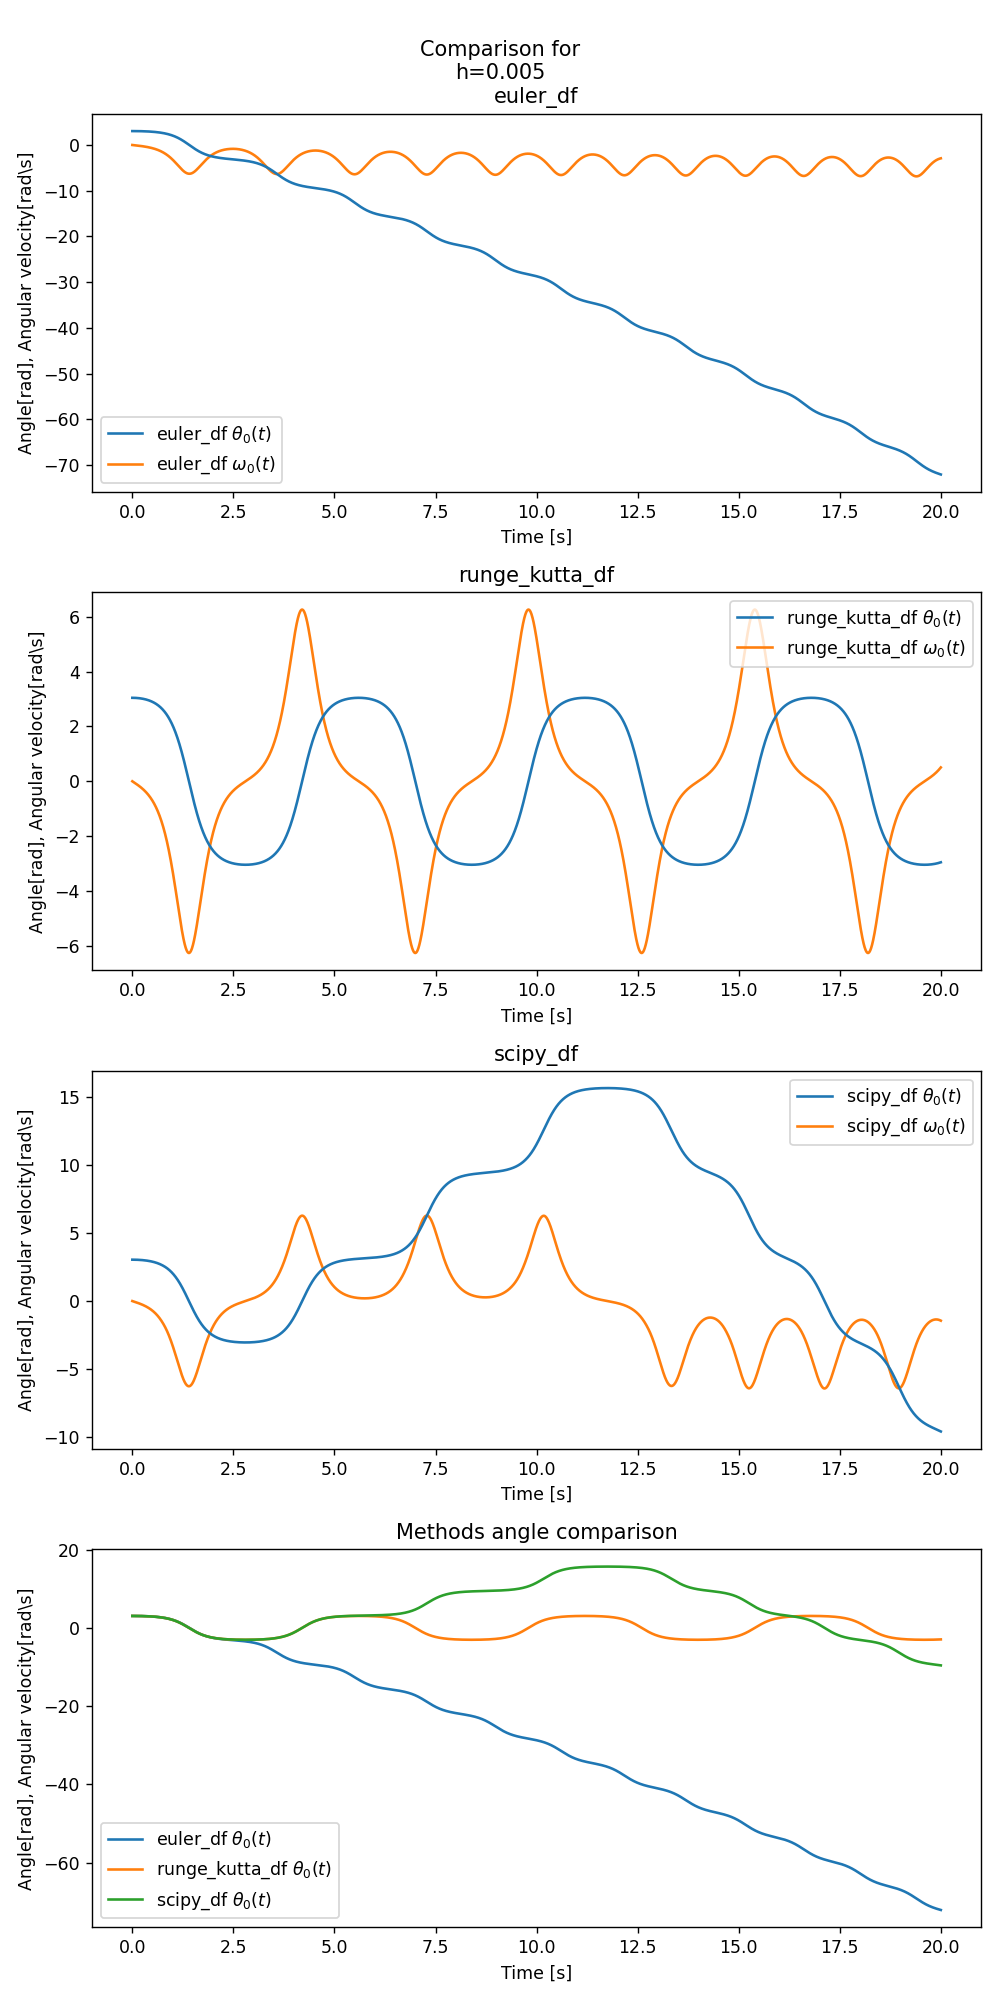

In [77]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac_extr, 0.005, methods)

Tylko Runge-Kutta dał zadowalające wyniki. Ponownie funckja biblioteczna miała problem z wahaniem się energii całkowitej układu, Euler skrupulatnie zwiększał swoją energię.

<IPython.core.display.Javascript object>


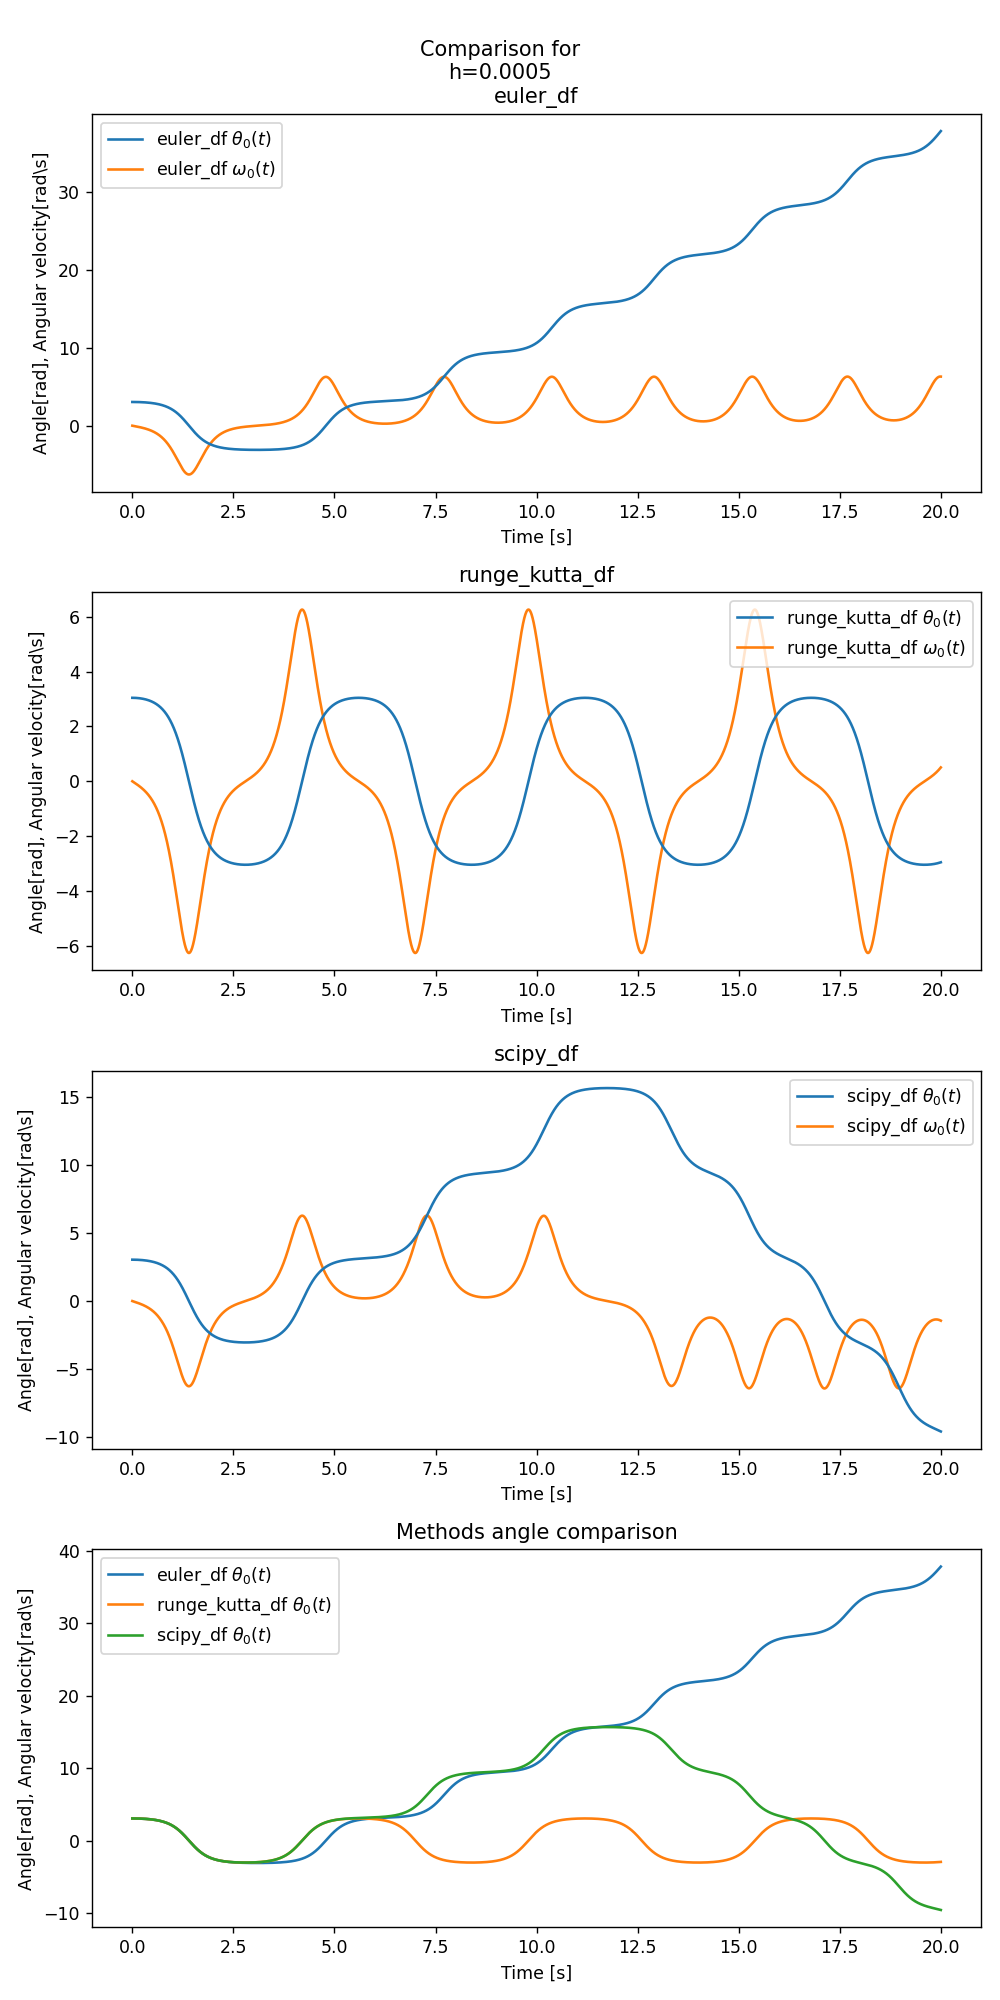

In [42]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac_extr, 0.0005, methods)

Ponownie funckja biblioteczna miała problem z wahaniem się energii całkowitej układu.

Euler wydaję się mniej przeszacowywać energię całkowitą, dając podobne wyniki dla początkowych wartości.

<IPython.core.display.Javascript object>


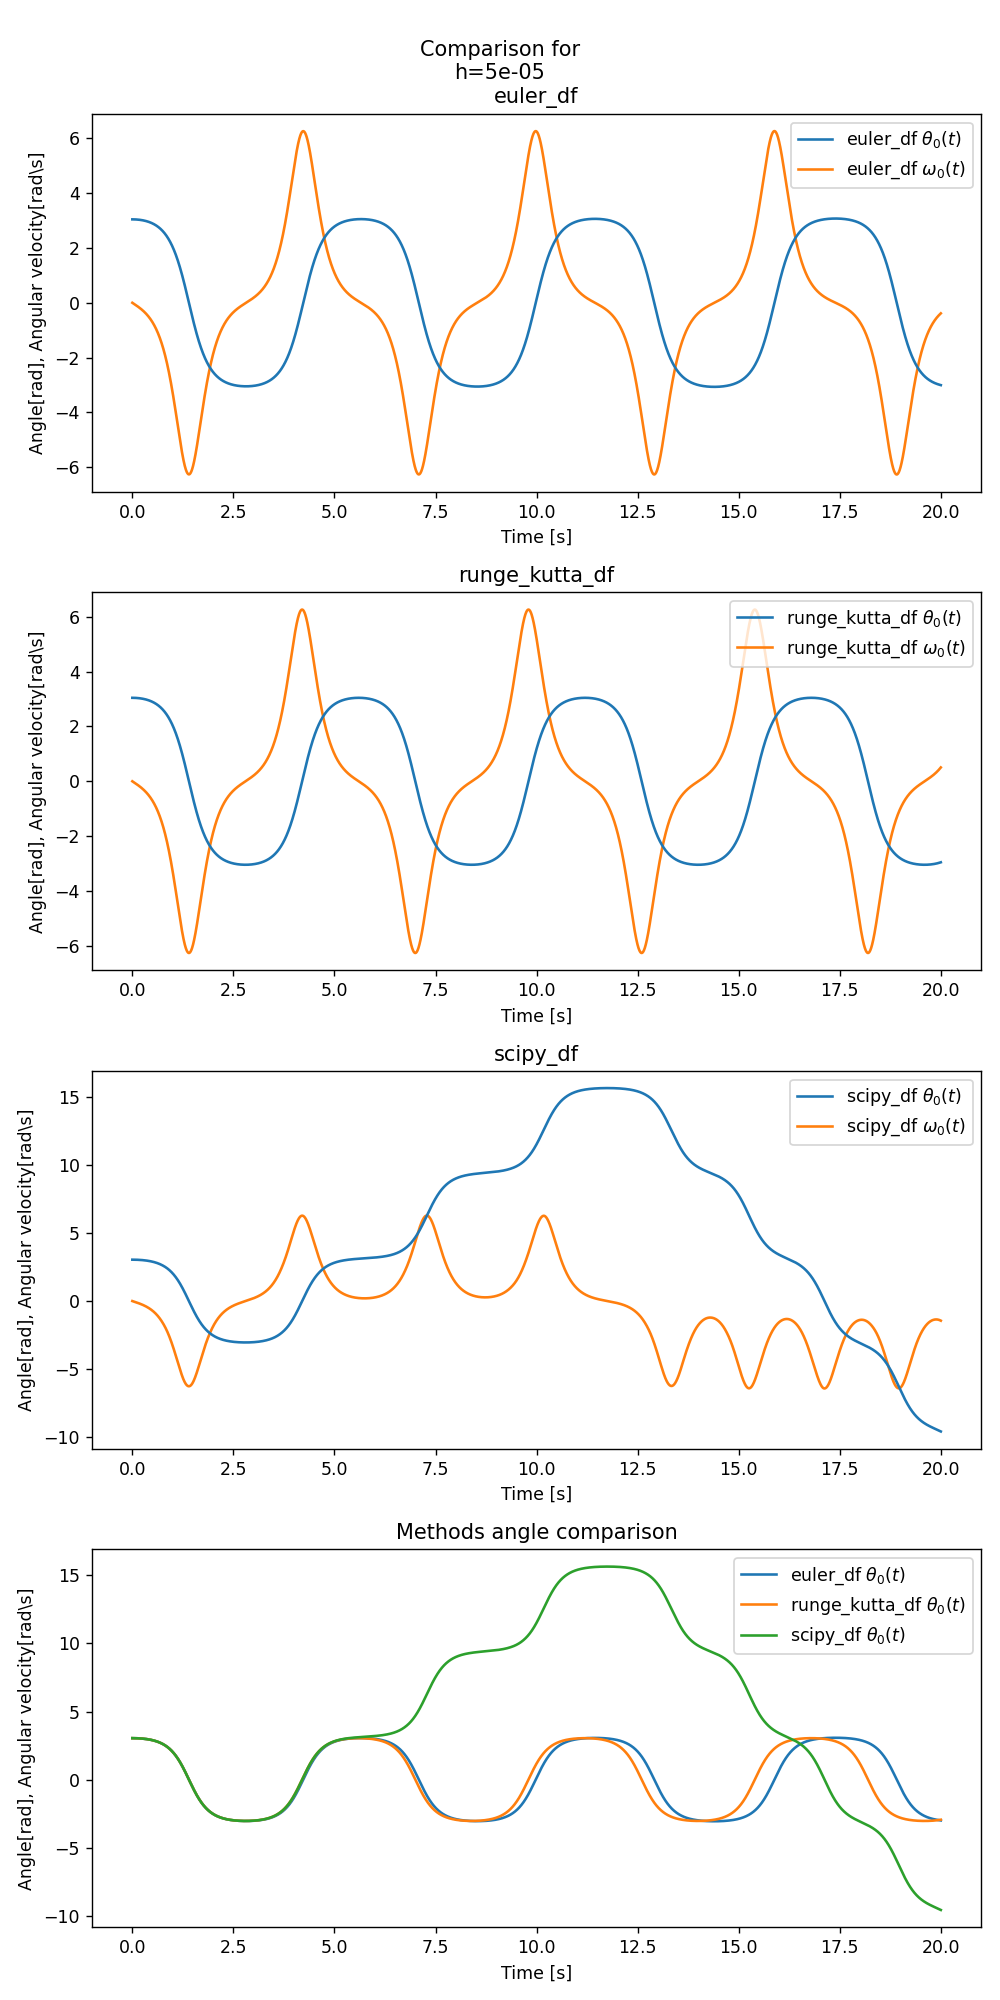

In [43]:
methods = [euler_df, runge_kutta_df, scipy_df]
compare_charts(pend_ac_extr, 0.00005, methods)

Wyniki Rungego-Kutty i Eulera stały się bardzo podobne, funkcja biblioteczna dalej generuje ten sam bład.

# Podwójne wahadło

Wyprowadzenia są dosyć mozolne, inspirowałem się tą stroną: https://matplotlib.org/3.2.2/gallery/animation/double_pendulum_sgskip.html

In [42]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

def derivs(t, state):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * np.cos(delta) * np.cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * np.sin(delta) * np.cos(delta)
                + M2 * G * np.sin(state[2]) * np.cos(delta)
                + M2 * L2 * state[3] * state[3] * np.sin(delta)
                - (M1+M2) * G * np.sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * np.sin(delta) * np.cos(delta)
                + (M1+M2) * G * np.sin(state[0]) * np.cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * np.sin(delta)
                - (M1+M2) * G * np.sin(state[2]))
               / den2)

    return dydx

In [43]:
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0
y0 = np.radians([th1, w1, th2, w2])

double_pend_ac = (derivs, (0, 20), y0)

### Podwójne wahadło, metoda Eulera

In [44]:
dt = 0.005
ts, us = euler_df(*double_pend_ac, h=dt)

pos_double_euler, vel_double_euler = us[:, 0::2], us[:, 1::2]
# pos_double_euler = np.fmod(pos_double_euler + 2 * np.pi, 4 * np.pi) - 2 * np.pi

<IPython.core.display.Javascript object>


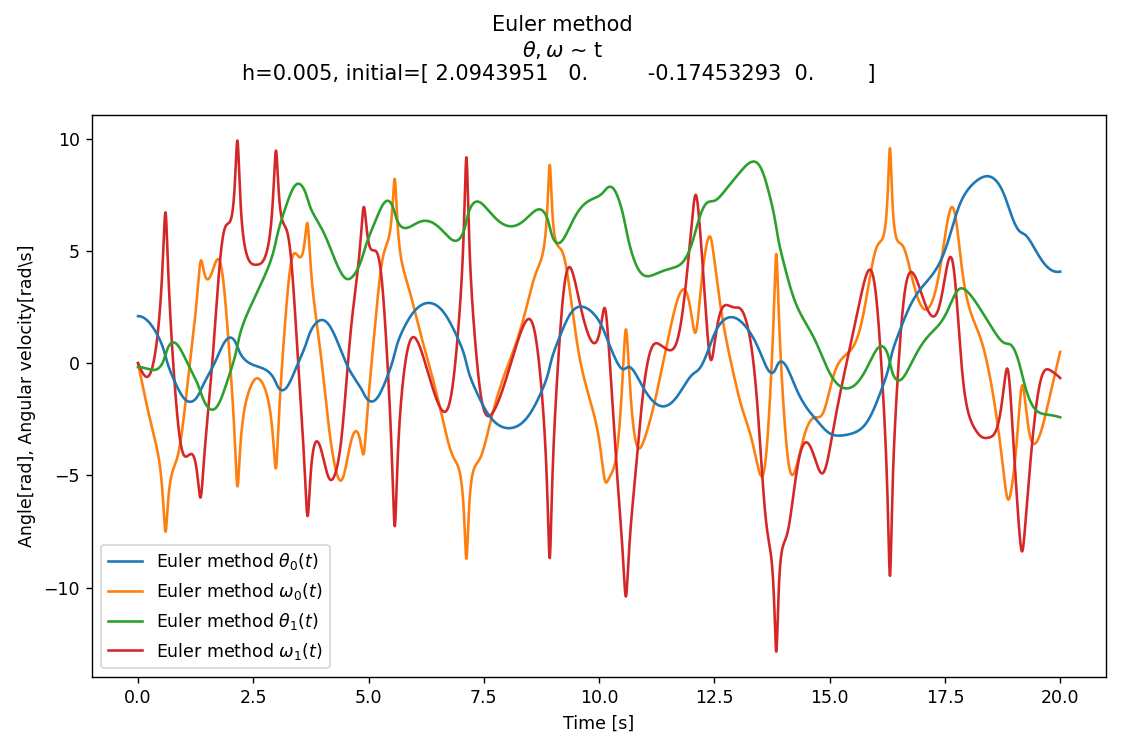

In [45]:
charts_pendulum(pos_double_euler, vel_double_euler, double_pend_ac, dt, ts, 'Euler method')

<IPython.core.display.Javascript object>


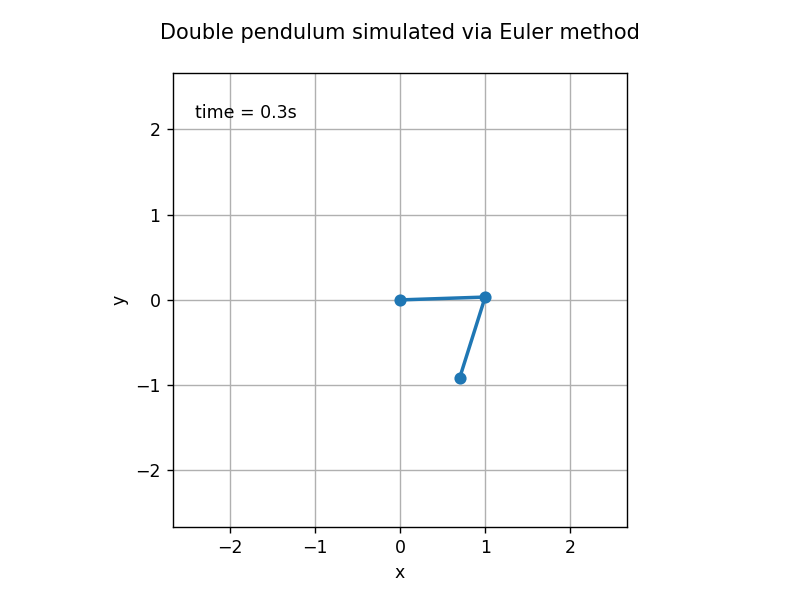

In [46]:
title = 'Double pendulum simulated via Euler method\n'
ani = animate_pendulum(pos_double_euler, np.array([L1, L2]), dt, title=title)
# ani.save('EulerDouble.gif', writer='imagemagick', fps=60)

Wykresy jasno pokazują chaotyczość całego układu.

### Podwójne wahadło, metoda Rungego-Kutty

In [47]:
dt = 0.005
ts, us = runge_kutta_df(*double_pend_ac, h=dt)

pos_double_runge, vel_double_runge = us[:, 0::2], us[:, 1::2]

<IPython.core.display.Javascript object>


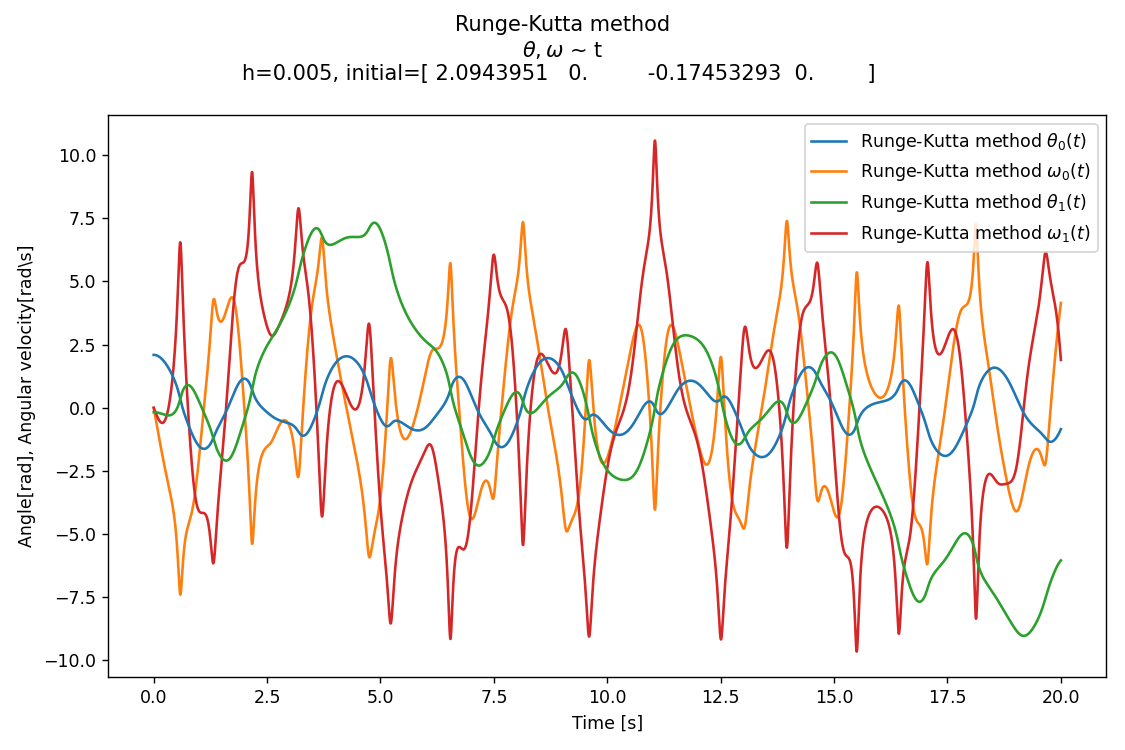

In [48]:
charts_pendulum(pos_double_runge, vel_double_runge, double_pend_ac, dt, ts, 'Runge-Kutta method')

<IPython.core.display.Javascript object>


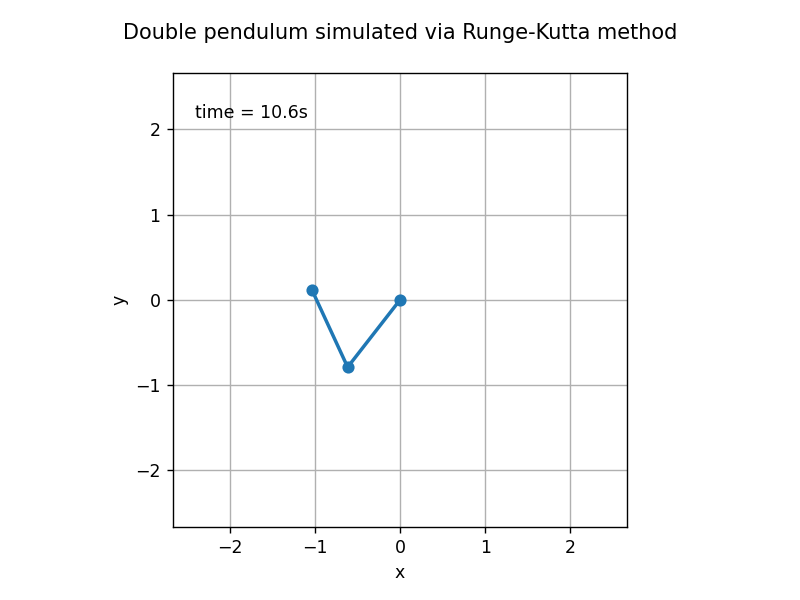

In [49]:
title = 'Double pendulum simulated via Runge-Kutta method\n'
ani = animate_pendulum(pos_double_runge, np.array([L1, L2]), dt, title=title)
# ani.save('RungeDouble.gif', writer='imagemagick', fps=60)

<IPython.core.display.Javascript object>


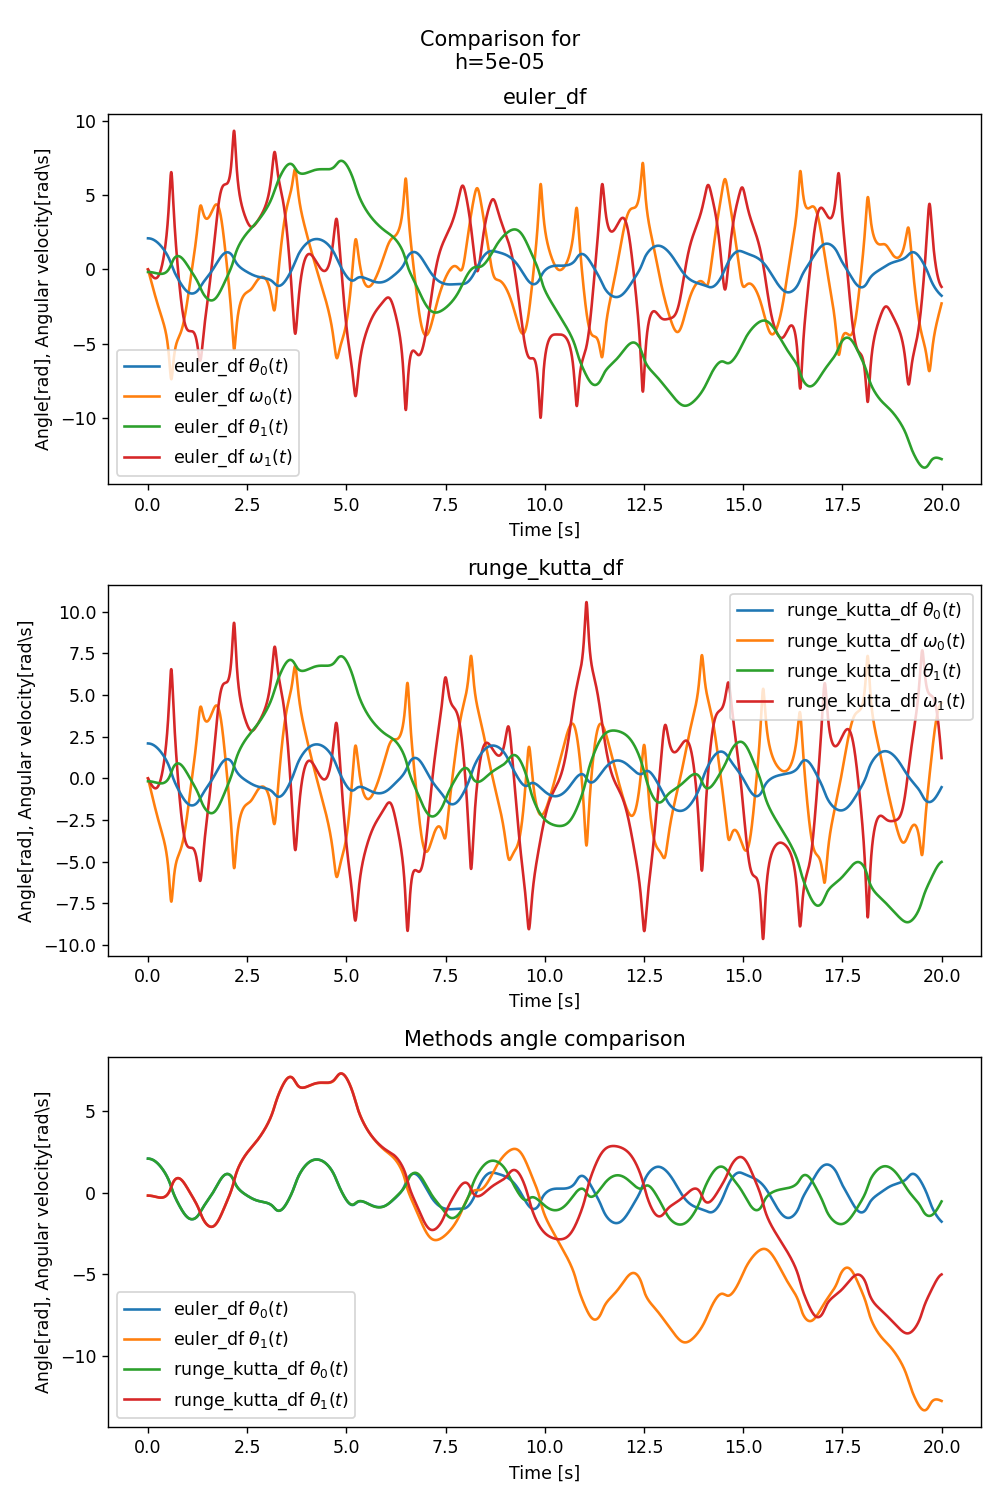

In [50]:
methods = [euler_df, runge_kutta_df]
compare_charts(double_pend_ac, 0.00005, methods)

Porównanie wykresów jasno pokazuję, że nawet dla bardzo małych wartości $h$ układy zachowują się podobnie tylko w pierwszych sekundach symulacji. 

## Porównanie wahadeł przy lekkich zmianach warunków początkowych

In [51]:
def animate_multiple_pendulums(thetass, lss, dt, title='', fig_axs=None):
    n_pends = len(thetass)
    if fig_axs is None:
        fig, axs = plt.subplots(n_pends, 1, figsize=(8, 5 * n_pends), autoscale_on=False)
#         fig = plt.figure()
#         ax = fig.add_subplot(111, )
    else:
        fig, axs = fig_axs
        axs = axs.flatten()
    lim = np.max(np.sum(lss, axis=1)) * 1.25
    for ax in axs:
        ax.set_aspect('equal')
        ax.grid()
        ax.set_ylim(-lim, lim)
        ax.set_xlim(-lim, lim)
    
    
    lines = [ax.plot([], [], 'o-', lw=2)[0] for ax in axs]
#     line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
#     ls = ls.reshape(1, -1)
    xss = []
    yss = []
    for ths, ls in zip(thetass, lss):
        xs = ls * np.sin(ths)
        ys = -ls * np.cos(ths)
        xss.append(xs)
        yss.append(ys)
    xss = np.array(xss)
    yss = np.array(yss)
    print(xss.shape)
    
    
    def init():
        for line in lines:
            line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        for line, xs, ys in zip(lines, xss, yss):
            thisx = [0, *np.cumsum(xs[i])]
            thisy = [0, *np.cumsum(ys[i])]
        
            line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*dt))
        return lines, time_text


    ani = animation.FuncAnimation(fig, animate, range(1, thetass.shape[1]),
                                  interval=dt*1000, blit=True, init_func=init)
    for ax in axs:
    #     ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    if fig_axs is None:
        fig.tight_layout()
        plt.show()
    return ani

In [52]:
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0
y0 = np.radians([th1, w1, th2, w2])

double_pend_ac = (derivs, (0, 20), y0)

In [53]:
epsilon = 1e-6
def runge_df_0(f, interval, y0, h):
    return runge_kutta_df(f, interval, y0, h=dt)

def runge_df_1(f, interval, y0, h):
    y0 += np.ones_like(y0) * epsilon
    return runge_kutta_df(f, interval, y0, h=dt)

def runge_df_2(f, interval, y0, h):
    y0 += np.ones_like(y0) * epsilon * 2
    return runge_kutta_df(f, interval, y0, h=dt)

def runge_df_3(f, interval, y0, h):
    y0 += np.ones_like(y0) * epsilon * 3
    return runge_kutta_df(f, interval, y0, h=dt)
methods = [runge_df_0, runge_df_1, runge_df_2, runge_df_3]

In [54]:
dt = 0.005

thetass = []
for method in methods:
    ts, us = method(*double_pend_ac, h=dt)
    pos, _ = us[:, 0::2], us[:, 1::2]
    thetass.append(pos)
thetass = np.array(thetass)


Różnice są już widoczne od około 10 sekundy.

<IPython.core.display.Javascript object>


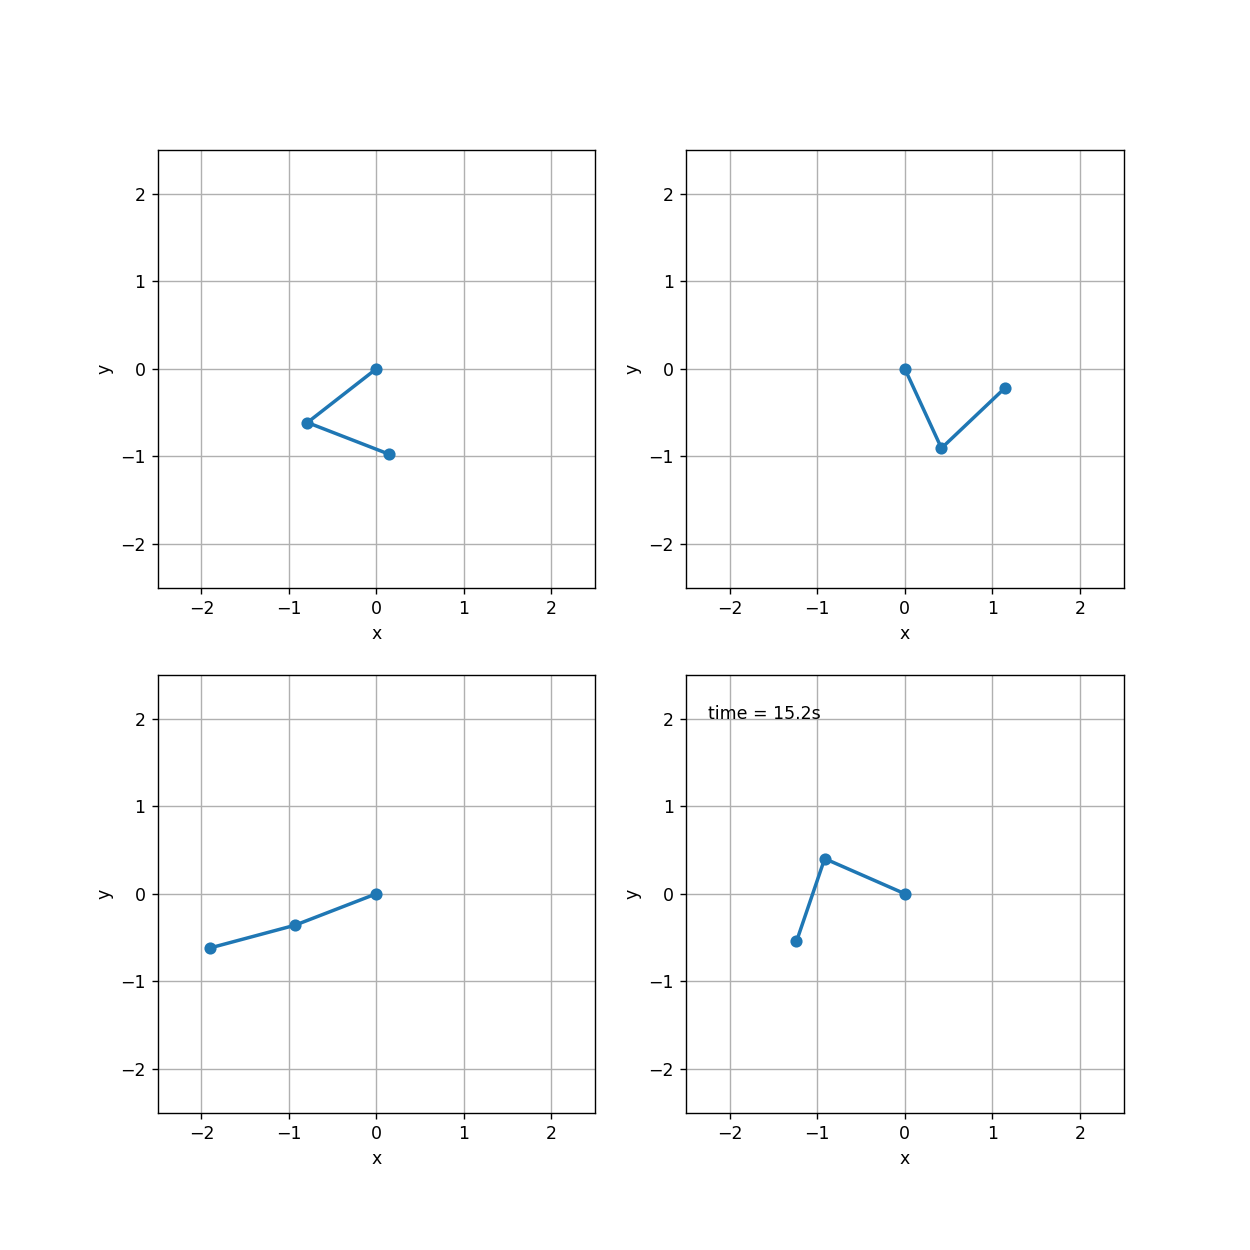

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
(4, 4001, 2)


In [55]:
title = 'Double pendulum simulated via Runge-Kutta method\n'
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = np.array(axs).flatten()
print(axs)
# thetass = np.array([pos_double_runge, pos_double_runge])
# print(thetass.shape)
lss = np.array([[1, 1] for _ in range(4)])
ani = animate_multiple_pendulums(thetass, lss, dt, title=title, fig_axs=(fig, axs))
plt.show()
# ani.save('RungeComp.gif', writer='imagemagick', fps=60)

<IPython.core.display.Javascript object>


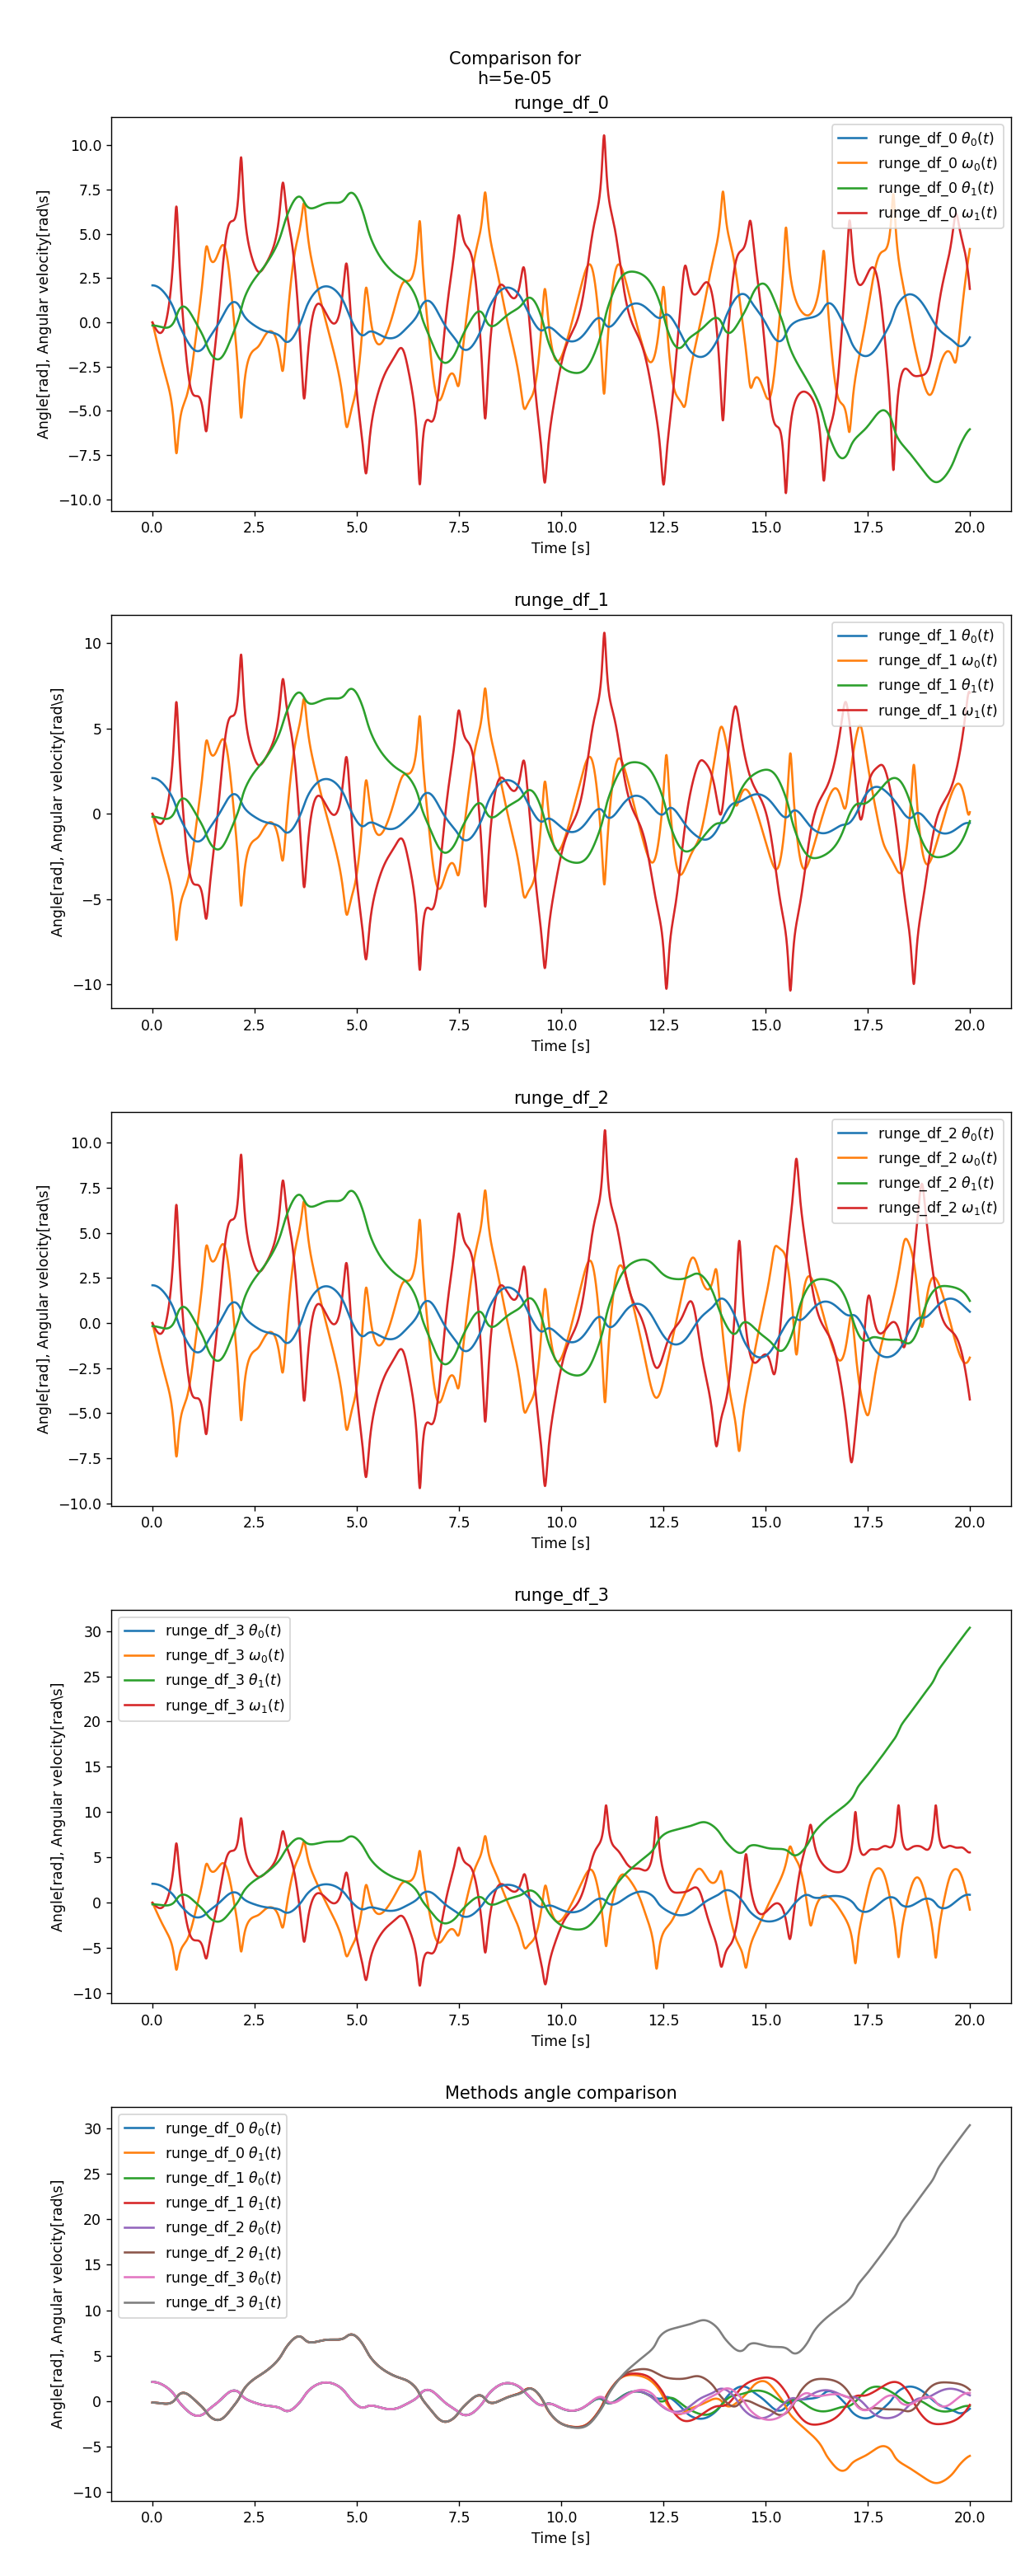

In [88]:
compare_charts(double_pend_ac, 0.00005, methods)

Niestabilność układu dla zmian rzędu $\epsilon = 10^{-6}$.